In [4]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 2
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.penalty = kwargs.get('penalty',-1)
        self.reward = kwargs.get('reward',1)
        self.k = kwargs.get('k',15)
        self.numiActions = self.k**2
        self.numActions = self.numiActions ** self.numPlayers
        
        self.eps = kwargs.get('eps',0.5)

        
        
        # Derived properties
        self.indexActions = self.init_indexActions()

        self.p_minmax_cost_1 = self.compute_p_competitive_monopoly(c = 1)
        self.init_actions()
        
        self.Profits,self.Penalty = self.init_Profits()
        self.Q = self.init_Q()
        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p, c):
        d = self.demand(p)
        zero = 1 - (p - c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p, c):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / self.mu + (p1 - c) * d1 / self.mu
        return np.squeeze(zero)
    
    
    def foc1_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+np.exp((self.a-p-self.a0)/self.mu))
        return zero
    def compute_p_monopoly_1(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc1_monopoly,p0,args = (c,))
        return p_monopoly
    
    
    def compute_p_competitive_2(self,c):
        p0 = c
        p_competitive = fsolve(self.foc2_competitive,p0,args = (c,))
        return p_competitive
    def foc2_competitive(self,p,c):
        zero = -p + c + self.mu*(1+1/(1+np.exp((-self.a+p+self.a0)/self.mu)))
        return zero
    
    
    def foc2_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+2*np.exp((self.a-p-self.a0)/self.mu))
        return zero
    def compute_p_monopoly_2(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc2_monopoly,p0,args = (c,))
        return p_monopoly

    
    def compute_p_competitive_monopoly(self, c):

        p_competitive = self.compute_p_competitive_2(c)
        p_monopoly = self.compute_p_monopoly_2(c)
        return p_competitive, p_monopoly

    
    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax_cost_1[0]), max(self.p_minmax_cost_1[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        self.player_actions = A
        self.player_cost = self.player_actions - self.mu*(1+1/(1 + \
                                      np.exp((self.a0-self.a+self.player_actions)/self.mu)))
        self.player_cost[np.abs(self.player_cost-self.c)<1e-5] = self.c
        self.buyer_action_list = np.array(list(product(A, repeat=2)))
        self.buyer_cost_list = np.array(list(product(self.player_cost, repeat=2)))
        self.seller_action_list = np.array(list(product(A, repeat=2)))
        self.seller_cost_list = np.array(list(product(self.player_cost, repeat=2)))
        
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p, c):
        d = self.demand(p)
        pi = (p - c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((2,self.numActions, self.numPlayers))
        Penalty = np.zeros((2,self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 4))
        
        for i in range(self.numActions):
#             b = int(self.indexActions[i][0])
#             b_brother = int(self.indexActions[i][1])
#             s = int(self.indexActions[i][2])
#             s_brother = int(self.indexActions[i][3])
            
#             cb = self.buyer_cost_list[b]
#             cs = self.seller_cost_list[s]
#             vb = self.buyer_action_list[b]
#             vs = self.seller_action_list[s]
#             cb_b = self.buyerbrother_cost_list[b_brother]
#             cs_b = self.sellerbrother_cost_list[s_brother]
#             vb_b = self.buyerbrother_action_list[b_brother]
#             vs_b = self.sellerbrother_action_list[s_brother]            
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            cb, cb_b = self.buyer_cost_list[b]
            cs, cs_b = self.seller_cost_list[s]
            vb, vb_b = self.buyer_action_list[b]
            vs, vs_b = self.seller_action_list[s]
            penalb = 0
            penals = 0
            pb = 0
            ps = 0
            
            Actions[i] = cb, cb_b, cs, cs_b
#             penalb = 0
#             penals = 0
#             penalb_b = 0
#             penals_b = 0
#             pb = 0
#             ps = 0
#             pb_b = 0
#             ps_b = 0
            
#             Actions[i] = cb, cs, vb, vs, cb_b, cs_b, vb_b, vs_b
            
            
            p_na = np.array([vb,vs])

            c_na = np.array([1,1])
            pb_na,ps_na = self.compute_profits(p_na,c_na)
            pb_b_na = pb_na
            pb_s_na = ps_na
            
                
        #AM mechanism starts here???SUN
#             if cb == cs:
            p = np.array([vb,vs])

            c = np.array([1,1])
            pb,ps = (1-self.eps)*self.compute_profits(p,c)
            pb_b = pb
            pb_s = ps

                
#             else:
#                 pb += 0.5*self.penalty
#                 ps += 0.5*self.penalty
#                 penals += 0.5*self.penalty
#                 penalb += 0.5*self.penalty
                
            price_b = self.compute_p_monopoly_1(c = cb_b)[0]
            p = np.array([price_b,100000])
            c = np.array([1,1])   
            pb_b,ps_b_ = self.eps*0.5*self.compute_profits(p,c)
                #pb = pb_b


#             price_s = self.compute_p_monopoly_1(c = cs_b)[0]
#             p = np.array([100000,price_s])
#             c = np.array([1,1])                
#             pb_b_,ps_b = self.eps*0.5*self.compute_profits(p,c)   
                #ps = ps_b

#             if cb == cs_b:
            if cb == 1:
                penalb = 0
                pb += 0

            else:
                penalb = self.penalty
                pb += self.penalty

            if cs == cb_b:
                penals =0
                ps += 0

            else:
                penals = self.penalty
                ps += self.penalty
            #End here？？？SUN

#             #4players mechanism
#             if cb == cs:
#                 p = np.array([vb,vs])

#                 c = np.array([1,1])
#                 pb,ps = self.compute_profits(p,c)
#                 pb_b = pb
#                 pb_s = ps

                
#             else:
#                 pb += 0.5*self.penalty
#                 ps += 0.5*self.penalty
#                 penals += 0.5*self.penalty
#                 penalb += 0.5*self.penalty
                
#                 price_b = self.compute_p_monopoly_1(c = cb_b)[0]
#                 p = np.array([price_b,100000])
#                 c = np.array([1,1])   
#                 pb_b,ps_b_ = self.compute_profits(p,c)
#                 #pb = pb_b


#                 price_s = self.compute_p_monopoly_1(c = cs_b)[0]
#                 p = np.array([100000,price_s])
#                 c = np.array([1,1])                
#                 pb_b_,ps_b = self.compute_profits(p,c)   
#                 #ps = ps_b

#                 if cb == cs_b:
#                     penalb = 0.5*self.reward
#                     pb += 0.5*self.reward

#                 else:
#                     penalb = 0.5*self.penalty
#                     pb += 0.5*self.penalty

#                 if cs == cb_b:
#                     penals = 0.5*self.reward
#                     ps += 0.5*self.reward

#                 else:
#                     penals = 0.5*self.penalty
#                     ps += 0.5*self.penalty
#             print('cb:',format(cb,'.2f'),'   cb_b:',format(cb_b,'.2f'),'   cs:',format(cs,'.2f'),\
#             '   cs_b:',format(cs_b,'.2f'),'   pb:',format(pb,'.2f'),'   ps:',format(ps,'.2f'),
#             '   pb_b:',format(pb_b,'.4f'),'   ps_b:',format(ps_b,'.4f'))

            Profits[1][i] = [pb, ps]
            #Penalty[1][i] = [penalb,penalb_b,penals,penals_b]
            Profits[0][i] = [pb_na,ps_na]
            #Penalty[0][i] = [penalb,penalb_b,penals,penals_b]            

        return Profits,Penalty
            
            

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [5]:
b_model = betrand_model()

In [3]:
b_model.buyer_action_list

array([[1.43525547, 1.43525547],
       [1.43525547, 1.47292666],
       [1.43525547, 1.51059785],
       [1.43525547, 1.54826904],
       [1.43525547, 1.58594022],
       [1.43525547, 1.62361141],
       [1.43525547, 1.6612826 ],
       [1.43525547, 1.69895379],
       [1.43525547, 1.73662498],
       [1.43525547, 1.77429617],
       [1.43525547, 1.81196735],
       [1.43525547, 1.84963854],
       [1.43525547, 1.88730973],
       [1.43525547, 1.92498092],
       [1.43525547, 1.96265211],
       [1.47292666, 1.43525547],
       [1.47292666, 1.47292666],
       [1.47292666, 1.51059785],
       [1.47292666, 1.54826904],
       [1.47292666, 1.58594022],
       [1.47292666, 1.62361141],
       [1.47292666, 1.6612826 ],
       [1.47292666, 1.69895379],
       [1.47292666, 1.73662498],
       [1.47292666, 1.77429617],
       [1.47292666, 1.81196735],
       [1.47292666, 1.84963854],
       [1.47292666, 1.88730973],
       [1.47292666, 1.92498092],
       [1.47292666, 1.96265211],
       [1.

In [6]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)
        self.c = kwargs.get('c',1)
        
        self.eps = kwargs.get('eps',0.5)

        self.game = betrand_model(delta = self.delta,true_value = self.true_value_index,\
                                   reward = self.reward,penalty = self.penalty,c = self.c,eps = self.eps)
        
        self.state_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        for i in range(15):
            if np.abs(self.game.player_cost[i] - self.c)<1e-5:
                self.c_index = i
#         print(self.game.player_cost)
#         print(self.c_index)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',10)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((2,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(self.game.numPlayers))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter
                old_strategy = strategyPrime.copy()                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                maxVal = np.max(self.Q[state1,:,:],axis = 0)
                    #print(iters,maxVal)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state2, iPlayer]
                    else:
                        profits = self.game.Profits[1][state2, iPlayer]
                        
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (profits + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1

                #print(pPrime)
                self.state_list[iSession,iters,:] = pPrime
                # Assessing convergence
                if iters>900000:
                    print([int(strategyPrime[0]//15),int(strategyPrime[0]%15),\
                           int(strategyPrime[1]//15),int(strategyPrime[1]%15)])
                vb,vb_b = self.game.buyer_action_list[int(old_strategy[0])]
                vs,vs_b = self.game.seller_action_list[int(old_strategy[1])]
                
                vb_1,vb_b_1 = self.game.buyer_action_list[int(strategyPrime[0])]
                vs_1,vs_b_1 = self.game.seller_action_list[int(strategyPrime[1])]  
                #print(strategyPrime,vb,vb_1,vs,vs_1)
                if vb == vb_1 and vs == vs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            #print(indexStrategies,strategyFix)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [9]:
b_model = betrand_model()


In [7]:
cost = b_model.player_cost
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 1,penalty = -2,reward = 2,c = cost[1],eps = 1,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()


print(R)


[1, 8, 13, 0]
[1, 5, 1, 4]
[1, 6, 11, 6]
[1, 13, 10, 6]
[1, 7, 13, 8]
[1, 12, 5, 3]
[1, 10, 13, 9]
[1, 1, 12, 5]
[1, 13, 11, 9]
[1, 3, 7, 8]
[1, 14, 1, 3]
[1, 13, 0, 2]
[1, 0, 13, 11]
[1, 8, 8, 14]
[1, 11, 2, 4]
[1, 14, 10, 0]
[1, 6, 4, 2]
[1, 3, 6, 5]
[1, 13, 8, 9]
[1, 13, 6, 8]
[1, 0, 13, 13]
[1, 9, 4, 13]
[1, 9, 14, 14]
[1, 7, 4, 14]
[1, 4, 4, 8]
[1, 6, 9, 14]
[1, 14, 5, 10]
[1, 3, 5, 9]
[1, 11, 3, 0]
[1, 3, 14, 7]
[1, 7, 1, 6]
[1, 12, 7, 12]
[1, 3, 10, 9]
[1, 7, 4, 10]
[1, 8, 0, 3]
[1, 5, 9, 3]
[1, 3, 0, 13]
[1, 11, 13, 3]
[1, 0, 4, 12]
[1, 8, 8, 8]
[1, 7, 13, 5]
[1, 5, 9, 11]
[1, 4, 6, 8]
[1, 0, 12, 1]
[1, 3, 2, 12]
[1, 4, 9, 7]
[1, 13, 12, 6]
[1, 10, 5, 7]
[1, 11, 14, 8]
[1, 13, 7, 0]
[1, 13, 3, 12]
[1, 7, 13, 3]
[1, 10, 6, 5]
[1, 11, 6, 4]
[1, 5, 0, 0]
[1, 14, 4, 9]
[1, 14, 12, 5]
[1, 13, 8, 11]
[1, 1, 6, 5]
[1, 1, 0, 14]
[1, 8, 7, 1]
[1, 3, 0, 2]
[1, 3, 2, 11]
[1, 5, 0, 11]
[1, 14, 10, 13]
[1, 2, 3, 6]
[1, 10, 11, 11]
[1, 14, 9, 0]
[1, 11, 8, 5]
[1, 0, 6, 5]
[1, 11, 10, 8]
[1, 

[1, 9, 11, 5]
[1, 13, 11, 8]
[1, 10, 2, 2]
[1, 8, 4, 7]
[1, 8, 10, 4]
[1, 4, 4, 11]
[1, 9, 12, 3]
[1, 6, 3, 9]
[1, 5, 10, 13]
[1, 0, 3, 13]
[1, 14, 9, 0]
[1, 6, 8, 5]
[1, 3, 2, 9]
[1, 3, 2, 14]
[1, 3, 10, 6]
[1, 8, 13, 10]
[1, 6, 0, 7]
[1, 12, 14, 14]
[1, 2, 8, 8]
[1, 1, 10, 7]
[1, 9, 7, 10]
[1, 13, 8, 0]
[1, 8, 5, 11]
[1, 11, 11, 9]
[1, 11, 14, 14]
[1, 9, 14, 4]
[1, 0, 5, 9]
[1, 7, 12, 12]
[1, 6, 0, 7]
[1, 8, 14, 14]
[1, 3, 7, 13]
[1, 3, 3, 9]
[1, 10, 10, 12]
[1, 13, 12, 14]
[1, 4, 10, 9]
[1, 5, 6, 12]
[1, 13, 4, 2]
[1, 2, 0, 13]
[1, 4, 0, 0]
[1, 12, 14, 13]
[1, 3, 5, 4]
[1, 0, 14, 3]
[1, 11, 7, 2]
[1, 5, 3, 11]
[1, 7, 5, 8]
[1, 5, 3, 0]
[1, 1, 4, 12]
[1, 9, 12, 11]
[1, 5, 12, 5]
[1, 3, 7, 5]
[1, 5, 6, 14]
[1, 5, 14, 13]
[1, 7, 4, 9]
[1, 11, 8, 2]
[1, 8, 12, 1]
[1, 8, 10, 5]
[1, 10, 13, 11]
[1, 5, 8, 5]
[1, 8, 8, 11]
[1, 2, 14, 8]
[1, 5, 0, 11]
[1, 4, 10, 13]
[1, 2, 5, 11]
[1, 3, 8, 10]
[1, 5, 2, 10]
[1, 4, 6, 0]
[1, 0, 4, 11]
[1, 8, 12, 4]
[1, 0, 6, 12]
[1, 3, 13, 3]
[1, 0, 11, 3]
[1

[1, 1, 5, 4]
[1, 6, 11, 11]
[1, 14, 4, 12]
[1, 6, 2, 6]
[1, 10, 8, 13]
[1, 12, 14, 7]
[1, 10, 8, 11]
[1, 13, 7, 10]
[1, 1, 11, 7]
[1, 10, 14, 3]
[1, 14, 0, 4]
[1, 0, 14, 2]
[1, 8, 5, 10]
[1, 14, 14, 3]
[1, 11, 9, 12]
[1, 5, 4, 8]
[1, 6, 2, 6]
[1, 7, 8, 13]
[1, 5, 8, 3]
[1, 11, 13, 14]
[1, 0, 7, 13]
[1, 5, 8, 14]
[1, 6, 14, 3]
[1, 10, 5, 11]
[1, 3, 2, 3]
[1, 8, 12, 12]
[1, 4, 9, 9]
[1, 7, 10, 7]
[1, 7, 2, 14]
[1, 11, 12, 4]
[1, 3, 0, 10]
[1, 0, 12, 0]
[1, 9, 14, 3]
[1, 5, 2, 4]
[1, 7, 2, 2]
[1, 10, 8, 11]
[1, 14, 7, 10]
[1, 10, 4, 13]
[1, 8, 9, 0]
[1, 5, 10, 1]
[1, 12, 1, 9]
[1, 5, 0, 12]
[1, 10, 4, 0]
[1, 9, 4, 3]
[1, 12, 8, 11]
[1, 2, 1, 10]
[1, 11, 5, 3]
[1, 10, 2, 6]
[1, 11, 6, 14]
[1, 2, 1, 2]
[1, 4, 4, 6]
[1, 4, 4, 5]
[1, 14, 13, 9]
[1, 11, 14, 0]
[1, 14, 2, 11]
[1, 4, 6, 6]
[1, 11, 0, 3]
[1, 10, 0, 6]
[1, 8, 12, 0]
[1, 12, 3, 14]
[1, 9, 13, 13]
[1, 10, 14, 7]
[1, 2, 8, 12]
[1, 8, 0, 14]
[1, 13, 10, 9]
[1, 0, 13, 12]
[1, 4, 0, 2]
[1, 13, 3, 4]
[1, 4, 13, 10]
[1, 4, 4, 14]
[1, 14, 

[1, 7, 6, 14]
[1, 6, 10, 0]
[1, 8, 0, 13]
[1, 13, 8, 14]
[1, 1, 3, 4]
[1, 9, 14, 14]
[1, 0, 14, 9]
[1, 11, 0, 14]
[1, 7, 9, 6]
[1, 8, 14, 7]
[1, 12, 3, 8]
[1, 5, 13, 4]
[1, 2, 13, 6]
[1, 14, 7, 12]
[1, 7, 9, 4]
[1, 1, 8, 8]
[1, 4, 7, 5]
[1, 0, 1, 12]
[1, 5, 5, 0]
[1, 11, 9, 11]
[1, 13, 2, 0]
[1, 14, 5, 9]
[1, 5, 6, 0]
[1, 0, 4, 8]
[1, 6, 9, 7]
[1, 1, 7, 5]
[1, 11, 12, 1]
[1, 8, 5, 9]
[1, 14, 9, 14]
[1, 0, 13, 11]
[1, 10, 8, 14]
[1, 1, 2, 13]
[1, 13, 6, 6]
[1, 6, 2, 14]
[1, 8, 1, 5]
[1, 0, 14, 1]
[1, 8, 0, 5]
[1, 4, 4, 8]
[1, 11, 9, 14]
[1, 2, 9, 9]
[1, 13, 0, 9]
[1, 12, 14, 9]
[1, 3, 1, 2]
[1, 1, 11, 4]
[1, 3, 2, 14]
[1, 13, 10, 6]
[1, 9, 13, 8]
[1, 4, 3, 4]
[1, 8, 8, 3]
[1, 2, 14, 4]
[1, 2, 5, 10]
[1, 12, 4, 4]
[1, 3, 11, 11]
[1, 10, 3, 0]
[1, 6, 10, 11]
[1, 6, 12, 13]
[1, 4, 0, 0]
[1, 6, 14, 13]
[1, 12, 11, 8]
[1, 9, 9, 1]
[1, 5, 7, 12]
[1, 7, 9, 13]
[1, 0, 3, 10]
[1, 10, 5, 5]
[1, 12, 14, 11]
[1, 4, 13, 4]
[1, 10, 5, 2]
[1, 5, 10, 7]
[1, 11, 0, 11]
[1, 3, 4, 3]
[1, 9, 5, 13]
[1, 8, 

[1, 11, 9, 14]
[1, 8, 11, 10]
[1, 12, 1, 10]
[1, 1, 14, 11]
[1, 11, 3, 10]
[1, 11, 9, 10]
[1, 1, 4, 0]
[1, 6, 14, 12]
[1, 1, 12, 2]
[1, 7, 7, 9]
[1, 4, 12, 8]
[1, 10, 6, 7]
[1, 9, 3, 6]
[1, 5, 3, 12]
[1, 12, 0, 1]
[1, 14, 5, 3]
[1, 0, 13, 9]
[1, 4, 9, 8]
[1, 9, 7, 2]
[1, 14, 6, 3]
[1, 11, 1, 3]
[1, 5, 1, 1]
[1, 6, 9, 4]
[1, 14, 12, 5]
[1, 12, 8, 11]
[1, 14, 1, 10]
[1, 1, 7, 8]
[1, 7, 3, 4]
[1, 13, 14, 4]
[1, 13, 12, 10]
[1, 6, 14, 11]
[1, 6, 13, 3]
[1, 5, 2, 8]
[1, 6, 0, 0]
[1, 5, 8, 11]
[1, 7, 11, 6]
[1, 2, 5, 11]
[1, 5, 8, 10]
[1, 7, 1, 6]
[1, 0, 7, 12]
[1, 2, 7, 12]
[1, 11, 6, 13]
[1, 0, 3, 8]
[1, 13, 7, 14]
[1, 0, 12, 9]
[1, 4, 12, 1]
[1, 6, 13, 4]
[1, 13, 6, 10]
[1, 10, 7, 1]
[1, 3, 5, 14]
[1, 5, 14, 7]
[1, 7, 14, 5]
[1, 6, 4, 5]
[1, 14, 2, 5]
[1, 14, 8, 13]
[1, 0, 1, 14]
[1, 11, 14, 1]
[1, 12, 14, 2]
[1, 13, 11, 10]
[1, 1, 8, 14]
[1, 14, 11, 8]
[1, 12, 9, 5]
[1, 12, 5, 0]
[1, 12, 14, 3]
[1, 2, 4, 0]
[1, 7, 5, 6]
[1, 4, 10, 1]
[1, 8, 9, 1]
[1, 12, 14, 10]
[1, 7, 3, 14]
[1, 8, 11, 

[1, 14, 8, 13]
[1, 3, 1, 12]
[1, 8, 8, 14]
[1, 5, 6, 13]
[1, 10, 0, 9]
[1, 6, 12, 7]
[1, 13, 7, 11]
[1, 7, 7, 1]
[1, 12, 11, 10]
[1, 10, 5, 9]
[1, 9, 5, 7]
[1, 10, 9, 9]
[1, 12, 3, 9]
[1, 10, 1, 7]
[1, 13, 8, 10]
[1, 2, 12, 12]
[1, 12, 8, 13]
[1, 4, 14, 12]
[1, 14, 3, 9]
[1, 8, 5, 9]
[1, 2, 9, 14]
[1, 6, 13, 12]
[1, 13, 6, 8]
[1, 0, 13, 13]
[1, 11, 4, 5]
[1, 3, 12, 13]
[1, 12, 7, 8]
[1, 12, 2, 5]
[1, 8, 11, 10]
[1, 13, 1, 10]
[1, 6, 7, 0]
[1, 11, 5, 12]
[1, 3, 7, 0]
[1, 8, 3, 10]
[1, 11, 6, 14]
[1, 6, 1, 2]
[1, 4, 6, 7]
[1, 11, 12, 13]
[1, 2, 10, 6]
[1, 9, 2, 14]
[1, 11, 9, 5]
[1, 3, 6, 0]
[1, 3, 7, 3]
[1, 9, 9, 9]
[1, 10, 0, 13]
[1, 12, 5, 11]
[1, 7, 9, 0]
[1, 14, 4, 3]
[1, 6, 9, 7]
[1, 4, 7, 5]
[1, 1, 1, 12]
[1, 10, 8, 1]
[1, 0, 0, 1]
[1, 9, 4, 0]
[1, 13, 10, 7]
[1, 12, 0, 3]
[1, 5, 10, 6]
[1, 8, 10, 7]
[1, 8, 5, 2]
[1, 13, 5, 8]
[1, 12, 12, 9]
[1, 11, 7, 4]
[1, 0, 9, 7]
[1, 3, 13, 14]
[1, 11, 3, 12]
[1, 12, 0, 13]
[1, 13, 4, 11]
[1, 11, 12, 7]
[1, 2, 13, 11]
[1, 8, 4, 14]
[1, 10, 9,

[1, 13, 9, 7]
[1, 0, 3, 0]
[1, 11, 13, 11]
[1, 10, 13, 10]
[1, 0, 14, 13]
[1, 1, 11, 7]
[1, 0, 14, 3]
[1, 13, 7, 2]
[1, 13, 8, 6]
[1, 12, 12, 4]
[1, 10, 6, 9]
[1, 3, 12, 12]
[1, 9, 1, 8]
[1, 7, 13, 10]
[1, 14, 13, 5]
[1, 13, 0, 0]
[1, 7, 11, 4]
[1, 5, 10, 9]
[1, 14, 12, 4]
[1, 0, 11, 7]
[1, 0, 3, 2]
[1, 12, 4, 6]
[1, 1, 8, 0]
[1, 6, 7, 13]
[1, 0, 9, 7]
[1, 5, 7, 0]
[1, 12, 11, 4]
[1, 11, 8, 10]
[1, 13, 8, 10]
[1, 4, 12, 12]
[1, 11, 2, 1]
[1, 8, 8, 11]
[1, 11, 14, 8]
[1, 8, 7, 0]
[1, 6, 6, 1]
[1, 11, 3, 14]
[1, 10, 11, 0]
[1, 7, 2, 11]
[1, 12, 8, 10]
[1, 8, 1, 4]
[1, 5, 1, 14]
[1, 1, 11, 2]
[1, 1, 13, 7]
[1, 6, 4, 12]
[1, 14, 7, 2]
[1, 5, 10, 10]
[1, 9, 11, 0]
[1, 10, 5, 5]
[1, 6, 12, 1]
[1, 14, 13, 8]
[1, 6, 13, 0]
[1, 4, 9, 12]
[1, 2, 0, 14]
[1, 13, 9, 3]
[1, 8, 7, 1]
[1, 2, 0, 2]
[1, 14, 7, 2]
[1, 14, 10, 10]
[1, 5, 8, 11]
[1, 13, 11, 6]
[1, 14, 9, 2]
[1, 3, 8, 8]
[1, 9, 10, 9]
[1, 8, 6, 10]
[1, 1, 0, 12]
[1, 13, 7, 2]
[1, 3, 8, 6]
[1, 10, 11, 4]
[1, 14, 6, 12]
[1, 7, 7, 5]
[1, 4, 7,

[1, 11, 6, 7]
[1, 10, 3, 13]
[1, 9, 14, 3]
[1, 12, 6, 5]
[1, 8, 5, 9]
[1, 10, 9, 14]
[1, 4, 12, 5]
[1, 6, 2, 13]
[1, 3, 8, 2]
[1, 2, 8, 11]
[1, 12, 8, 3]
[1, 5, 7, 3]
[1, 0, 11, 1]
[1, 12, 3, 0]
[1, 12, 2, 14]
[1, 10, 14, 4]
[1, 3, 13, 6]
[1, 0, 6, 14]
[1, 3, 4, 2]
[1, 10, 5, 10]
[1, 4, 11, 3]
[1, 4, 5, 0]
[1, 8, 10, 3]
[1, 4, 6, 12]
[1, 14, 5, 3]
[1, 12, 13, 9]
[1, 9, 1, 11]
[1, 14, 2, 11]
[1, 10, 6, 6]
[1, 3, 12, 7]
[1, 5, 12, 4]
[1, 2, 12, 6]
[1, 5, 11, 4]
[1, 2, 14, 14]
[1, 13, 12, 5]
[1, 8, 4, 5]
[1, 14, 7, 14]
[1, 10, 13, 8]
[1, 4, 1, 1]
[1, 5, 8, 10]
[1, 10, 1, 6]
[1, 0, 11, 12]
[1, 9, 6, 5]
[1, 2, 4, 12]
[1, 10, 1, 3]
[1, 6, 1, 11]
[1, 7, 5, 13]
[1, 7, 5, 10]
[1, 11, 10, 8]
[1, 8, 10, 0]
[1, 3, 1, 11]
[1, 10, 2, 9]
[1, 9, 11, 3]
[1, 8, 4, 13]
[1, 13, 4, 1]
[1, 6, 0, 13]
[1, 5, 13, 2]
[1, 12, 6, 14]
[1, 2, 10, 10]
[1, 14, 11, 11]
[1, 6, 3, 12]
[1, 12, 13, 2]
[1, 5, 8, 13]
[1, 3, 8, 3]
[1, 9, 7, 9]
[1, 11, 13, 9]
[1, 10, 3, 2]
[1, 9, 4, 11]
[1, 3, 12, 12]
[1, 9, 1, 8]
[1, 6, 13, 

[1, 2, 8, 0]
[1, 11, 13, 9]
[1, 2, 3, 2]
[1, 6, 9, 6]
[1, 11, 13, 7]
[1, 5, 5, 12]
[1, 2, 14, 8]
[1, 11, 0, 11]
[1, 10, 4, 3]
[1, 14, 13, 9]
[1, 14, 14, 0]
[1, 9, 4, 11]
[1, 14, 12, 12]
[1, 1, 8, 13]
[1, 10, 13, 12]
[1, 3, 11, 7]
[1, 2, 6, 10]
[1, 14, 1, 3]
[1, 10, 0, 2]
[1, 1, 13, 2]
[1, 5, 10, 7]
[1, 1, 2, 0]
[1, 9, 10, 3]
[1, 4, 11, 11]
[1, 9, 0, 13]
[1, 6, 9, 2]
[1, 11, 13, 4]
[1, 8, 4, 0]
[1, 11, 9, 14]
[1, 3, 11, 10]
[1, 13, 12, 3]
[1, 6, 3, 10]
[1, 4, 13, 12]
[1, 3, 1, 8]
[1, 7, 1, 13]
[1, 8, 1, 8]
[1, 9, 5, 4]
[1, 7, 5, 0]
[1, 13, 0, 14]
[1, 7, 9, 9]
[1, 9, 10, 3]
[1, 2, 11, 11]
[1, 5, 9, 7]
[1, 3, 12, 11]
[1, 11, 3, 9]
[1, 9, 2, 9]
[1, 2, 6, 11]
[1, 4, 8, 9]
[1, 7, 8, 12]
[1, 10, 10, 11]
[1, 10, 5, 6]
[1, 5, 5, 1]
[1, 12, 5, 2]
[1, 12, 6, 8]
[1, 6, 0, 3]
[1, 5, 7, 13]
[1, 3, 1, 10]
[1, 6, 7, 2]
[1, 4, 14, 8]
[1, 9, 4, 1]
[1, 7, 3, 7]
[1, 3, 13, 12]
[1, 13, 0, 6]
[1, 0, 4, 4]
[1, 9, 5, 11]
[1, 7, 8, 3]
[1, 9, 6, 8]
[1, 10, 11, 2]
[1, 1, 11, 6]
[1, 0, 3, 12]
[1, 5, 4, 3]
[1, 4, 

[1, 11, 0, 0]
[1, 8, 9, 2]
[1, 7, 2, 10]
[1, 7, 12, 4]
[1, 11, 2, 14]
[1, 6, 4, 1]
[1, 7, 13, 6]
[1, 6, 3, 0]
[1, 6, 2, 11]
[1, 6, 1, 7]
[1, 12, 14, 8]
[1, 1, 8, 2]
[1, 5, 2, 5]
[1, 13, 10, 7]
[1, 5, 0, 3]
[1, 0, 6, 3]
[1, 7, 5, 9]
[1, 0, 13, 0]
[1, 13, 6, 13]
[1, 5, 6, 9]
[1, 14, 13, 12]
[1, 2, 14, 13]
[1, 11, 12, 7]
[1, 10, 13, 11]
[1, 10, 8, 5]
[1, 8, 4, 2]
[1, 9, 1, 12]
[1, 11, 10, 5]
[1, 9, 6, 0]
[1, 0, 10, 1]
[1, 4, 9, 14]
[1, 9, 0, 14]
[1, 1, 4, 5]
[1, 1, 1, 13]
[1, 3, 11, 10]
[1, 14, 12, 3]
[1, 7, 14, 9]
[1, 14, 2, 3]
[1, 5, 9, 5]
[1, 10, 7, 7]
[1, 6, 0, 7]
[1, 8, 14, 14]
[1, 12, 7, 13]
[1, 14, 4, 13]
[1, 3, 9, 5]
[1, 6, 7, 11]
[1, 4, 10, 7]
[1, 2, 8, 10]
[1, 5, 13, 12]
[1, 4, 9, 2]
[1, 4, 8, 11]
[1, 8, 7, 2]
[1, 13, 2, 0]
[1, 0, 8, 7]
[1, 0, 3, 12]
[1, 0, 4, 3]
[1, 9, 4, 4]
[1, 12, 9, 5]
[1, 7, 5, 0]
[1, 1, 0, 14]
[1, 0, 6, 11]
[1, 8, 2, 2]
[1, 3, 4, 12]
[1, 12, 8, 8]
[1, 5, 7, 5]
[1, 10, 9, 7]
[1, 8, 8, 3]
[1, 3, 4, 14]
[1, 5, 3, 7]
[1, 3, 0, 14]
[1, 13, 4, 11]
[1, 10, 12, 7]

[1, 6, 9, 13]
[1, 8, 11, 8]
[1, 7, 11, 3]
[1, 5, 4, 13]
[1, 8, 12, 12]
[1, 0, 9, 9]
[1, 8, 1, 6]
[1, 3, 4, 6]
[1, 4, 6, 13]
[1, 14, 2, 3]
[1, 14, 9, 5]
[1, 3, 13, 13]
[1, 10, 7, 12]
[1, 14, 7, 8]
[1, 11, 9, 12]
[1, 2, 11, 13]
[1, 10, 4, 9]
[1, 8, 8, 3]
[1, 10, 9, 12]
[1, 9, 11, 8]
[1, 11, 0, 13]
[1, 9, 0, 14]
[1, 5, 7, 0]
[1, 1, 14, 1]
[1, 2, 14, 3]
[1, 14, 6, 11]
[1, 14, 11, 2]
[1, 7, 12, 5]
[1, 8, 8, 1]
[1, 1, 10, 2]
[1, 7, 7, 12]
[1, 5, 9, 2]
[1, 5, 11, 9]
[1, 14, 0, 3]
[1, 4, 8, 1]
[1, 5, 11, 2]
[1, 0, 0, 8]
[1, 7, 8, 3]
[1, 11, 6, 8]
[1, 7, 13, 7]
[1, 3, 13, 5]
[1, 2, 9, 0]
[1, 13, 13, 12]
[1, 14, 8, 8]
[1, 13, 7, 2]
[1, 2, 8, 6]
[1, 14, 6, 10]
[1, 8, 7, 12]
[1, 0, 8, 5]
[1, 8, 12, 5]
[1, 12, 6, 8]
[1, 10, 2, 11]
[1, 12, 4, 2]
[1, 11, 4, 10]
[1, 4, 10, 11]
[1, 1, 4, 12]
[1, 11, 12, 11]
[1, 3, 10, 6]
[1, 13, 13, 10]
[1, 6, 3, 14]
[1, 7, 10, 11]
[1, 7, 2, 3]
[1, 3, 0, 11]
[1, 2, 4, 0]
[1, 5, 5, 6]
[1, 4, 2, 2]
[1, 1, 9, 9]
[1, 4, 9, 7]
[1, 12, 11, 7]
[1, 10, 10, 11]
[1, 9, 5, 6]
[1,

[1, 5, 1, 13]
[1, 10, 11, 6]
[1, 0, 9, 0]
[1, 8, 12, 5]
[1, 13, 6, 8]
[1, 10, 13, 13]
[1, 1, 9, 1]
[1, 10, 11, 0]
[1, 7, 2, 11]
[1, 6, 11, 8]
[1, 0, 0, 13]
[1, 10, 2, 1]
[1, 5, 13, 13]
[1, 13, 10, 1]
[1, 5, 11, 11]
[1, 2, 14, 13]
[1, 4, 12, 7]
[1, 10, 12, 2]
[1, 7, 6, 11]
[1, 0, 7, 3]
[1, 3, 6, 2]
[1, 5, 3, 12]
[1, 5, 0, 1]
[1, 5, 14, 13]
[1, 11, 2, 5]
[1, 7, 14, 10]
[1, 7, 4, 8]
[1, 1, 11, 2]
[1, 13, 13, 7]
[1, 10, 7, 14]
[1, 14, 5, 14]
[1, 5, 1, 12]
[1, 1, 14, 3]
[1, 8, 8, 6]
[1, 5, 2, 14]
[1, 3, 7, 12]
[1, 9, 2, 7]
[1, 3, 8, 1]
[1, 11, 12, 4]
[1, 1, 9, 0]
[1, 0, 4, 0]
[1, 9, 12, 2]
[1, 12, 2, 7]
[1, 14, 7, 2]
[1, 13, 8, 3]
[1, 3, 4, 7]
[1, 10, 5, 12]
[1, 8, 12, 7]
[1, 7, 11, 11]
[1, 4, 12, 7]
[1, 9, 12, 2]
[1, 5, 2, 7]
[1, 4, 12, 8]
[1, 8, 5, 3]
[1, 9, 11, 0]
[1, 3, 5, 5]
[1, 14, 2, 12]
[1, 14, 2, 2]
[1, 6, 8, 12]
[1, 12, 0, 7]
[1, 11, 1, 4]
[1, 0, 11, 1]
[1, 5, 3, 0]
[1, 11, 4, 12]
[1, 6, 9, 7]
[1, 9, 7, 5]
[1, 5, 11, 12]
[1, 1, 8, 10]
[1, 11, 10, 3]
[1, 7, 8, 7]
[1, 9, 6, 1]
[1, 7

[1, 8, 5, 4]
[1, 7, 7, 10]
[1, 2, 14, 10]
[1, 7, 9, 1]
[1, 10, 7, 13]
[1, 5, 4, 6]
[1, 11, 8, 13]
[1, 6, 5, 4]
[1, 7, 4, 13]
[1, 13, 10, 11]
[1, 9, 10, 8]
[1, 8, 5, 1]
[1, 8, 8, 11]
[1, 4, 0, 14]
[1, 6, 13, 8]
[1, 6, 2, 6]
[1, 1, 8, 13]
[1, 5, 13, 12]
[1, 4, 0, 3]
[1, 5, 5, 7]
[1, 1, 0, 9]
[1, 3, 6, 9]
[1, 5, 12, 0]
[1, 11, 10, 7]
[1, 3, 3, 6]
[1, 7, 13, 13]
[1, 11, 12, 1]
[1, 4, 5, 9]
[1, 0, 6, 14]
[1, 8, 1, 6]
[1, 8, 8, 1]
[1, 8, 10, 2]
[1, 10, 10, 12]
[1, 12, 0, 2]
[1, 2, 9, 4]
[1, 9, 7, 0]
[1, 7, 4, 3]
[1, 4, 6, 14]
[1, 9, 12, 9]
[1, 10, 7, 14]
[1, 3, 5, 14]
[1, 0, 14, 7]
[1, 8, 12, 7]
[1, 14, 11, 11]
[1, 10, 3, 12]
[1, 0, 13, 7]
[1, 12, 10, 6]
[1, 7, 0, 0]
[1, 13, 0, 0]
[1, 6, 11, 4]
[1, 11, 8, 0]
[1, 12, 8, 10]
[1, 14, 1, 4]
[1, 14, 12, 8]
[1, 2, 0, 12]
[1, 13, 7, 4]
[1, 7, 8, 12]
[1, 11, 10, 11]
[1, 6, 3, 2]
[1, 12, 11, 12]
[1, 10, 7, 1]
[1, 9, 2, 12]
[1, 12, 8, 13]
[1, 12, 14, 12]
[1, 12, 3, 1]
[1, 1, 2, 8]
[1, 12, 9, 8]
[1, 4, 5, 8]
[1, 10, 3, 7]
[1, 3, 10, 4]
[1, 6, 7, 8]
[1,

[1, 5, 3, 13]
[1, 11, 7, 7]
[1, 8, 12, 10]
[1, 8, 14, 14]
[1, 2, 7, 13]
[1, 14, 2, 4]
[1, 2, 12, 10]
[1, 12, 9, 13]
[1, 14, 4, 9]
[1, 0, 12, 5]
[1, 2, 6, 1]
[1, 11, 14, 5]
[1, 10, 12, 0]
[1, 11, 8, 3]
[1, 3, 2, 2]
[1, 14, 11, 4]
[1, 2, 4, 10]
[1, 0, 13, 2]
[1, 8, 2, 4]
[1, 14, 12, 3]
[1, 7, 14, 9]
[1, 1, 2, 3]
[1, 6, 13, 2]
[1, 13, 11, 2]
[1, 3, 10, 5]
[1, 12, 3, 0]
[1, 4, 2, 14]
[1, 0, 0, 2]
[1, 3, 1, 13]
[1, 11, 3, 11]
[1, 2, 10, 13]
[1, 6, 14, 0]
[1, 13, 2, 6]
[1, 10, 9, 2]
[1, 1, 6, 4]
[1, 2, 1, 9]
[1, 0, 7, 9]
[1, 4, 11, 8]
[1, 14, 0, 4]
[1, 3, 14, 2]
[1, 11, 4, 8]
[1, 11, 6, 8]
[1, 13, 13, 7]
[1, 3, 7, 14]
[1, 13, 14, 0]
[1, 10, 12, 9]
[1, 9, 13, 13]
[1, 9, 14, 7]
[1, 6, 9, 7]
[1, 9, 7, 5]
[1, 13, 11, 12]
[1, 4, 14, 4]
[1, 6, 4, 3]
[1, 5, 11, 4]
[1, 7, 14, 14]
[1, 1, 14, 0]
[1, 7, 3, 11]
[1, 2, 12, 5]
[1, 6, 1, 2]
[1, 2, 6, 7]
[1, 5, 11, 12]
[1, 13, 8, 10]
[1, 6, 12, 12]
[1, 7, 5, 11]
[1, 11, 4, 5]
[1, 12, 8, 6]
[1, 14, 2, 9]
[1, 14, 3, 0]
[1, 11, 9, 7]
[1, 12, 14, 10]
[1, 12, 3,

[1, 13, 13, 8]
[1, 4, 9, 9]
[1, 11, 10, 7]
[1, 2, 3, 6]
[1, 4, 11, 11]
[1, 9, 13, 5]
[1, 9, 4, 12]
[1, 13, 14, 14]
[1, 3, 0, 0]
[1, 14, 9, 9]
[1, 2, 5, 2]
[1, 11, 14, 11]
[1, 14, 10, 7]
[1, 3, 8, 13]
[1, 14, 1, 12]
[1, 1, 13, 3]
[1, 13, 6, 5]
[1, 13, 1, 10]
[1, 8, 7, 0]
[1, 9, 6, 1]
[1, 12, 5, 14]
[1, 14, 9, 4]
[1, 13, 7, 14]
[1, 13, 12, 9]
[1, 3, 13, 12]
[1, 3, 10, 9]
[1, 12, 12, 8]
[1, 5, 1, 3]
[1, 2, 14, 0]
[1, 3, 12, 5]
[1, 12, 0, 11]
[1, 9, 3, 2]
[1, 9, 8, 13]
[1, 5, 13, 13]
[1, 1, 14, 11]
[1, 5, 3, 10]
[1, 6, 5, 2]
[1, 2, 14, 0]
[1, 5, 12, 5]
[1, 6, 7, 5]
[1, 1, 8, 4]
[1, 12, 2, 4]
[1, 4, 1, 13]
[1, 9, 4, 11]
[1, 3, 2, 14]
[1, 11, 10, 6]
[1, 13, 14, 8]
[1, 3, 8, 8]
[1, 6, 10, 9]
[1, 0, 2, 14]
[1, 6, 3, 3]
[1, 12, 4, 2]
[1, 7, 4, 10]
[1, 10, 0, 3]
[1, 8, 0, 9]
[1, 3, 13, 9]
[1, 0, 13, 1]
[1, 9, 14, 13]
[1, 10, 10, 12]
[1, 14, 0, 2]
[1, 3, 12, 1]
[1, 13, 0, 1]
[1, 11, 7, 2]
[1, 0, 3, 13]
[1, 7, 3, 1]
[1, 7, 8, 5]
[1, 0, 1, 4]
[1, 14, 1, 8]
[1, 8, 1, 10]
[1, 13, 4, 5]
[1, 14, 5, 5]


[1, 9, 7, 5]
[1, 11, 11, 12]
[1, 13, 6, 6]
[1, 12, 2, 14]
[1, 5, 14, 4]
[1, 0, 8, 2]
[1, 13, 5, 9]
[1, 5, 1, 4]
[1, 13, 11, 6]
[1, 11, 2, 9]
[1, 14, 1, 14]
[1, 1, 2, 1]
[1, 13, 5, 7]
[1, 12, 5, 13]
[1, 4, 3, 0]
[1, 14, 1, 8]
[1, 13, 1, 10]
[1, 6, 7, 0]
[1, 10, 5, 12]
[1, 5, 12, 7]
[1, 2, 0, 6]
[1, 2, 1, 8]
[1, 6, 10, 11]
[1, 10, 11, 14]
[1, 5, 12, 6]
[1, 4, 3, 5]
[1, 5, 13, 9]
[1, 1, 2, 4]
[1, 0, 10, 7]
[1, 8, 12, 8]
[1, 6, 13, 5]
[1, 7, 2, 4]
[1, 1, 3, 8]
[1, 0, 3, 8]
[1, 10, 12, 10]
[1, 7, 14, 11]
[1, 13, 8, 1]
[1, 12, 4, 5]
[1, 3, 6, 6]
[1, 7, 1, 0]
[1, 2, 3, 14]
[1, 4, 3, 6]
[1, 2, 13, 4]
[1, 13, 2, 9]
[1, 8, 1, 10]
[1, 7, 4, 5]
[1, 0, 3, 11]
[1, 3, 12, 0]
[1, 6, 12, 5]
[1, 2, 7, 7]
[1, 11, 7, 14]
[1, 7, 10, 14]
[1, 8, 13, 0]
[1, 11, 5, 3]
[1, 12, 2, 6]
[1, 14, 13, 6]
[1, 9, 12, 1]
[1, 9, 11, 11]
[1, 2, 13, 4]
[1, 11, 2, 9]
[1, 5, 1, 14]
[1, 8, 6, 6]
[1, 5, 5, 13]
[1, 3, 1, 2]
[1, 11, 11, 4]
[1, 11, 1, 7]
[1, 0, 11, 11]
[1, 14, 7, 9]
[1, 12, 3, 12]
[1, 7, 8, 7]
[1, 1, 6, 1]
[1, 4, 

[1, 13, 6, 7]
[1, 3, 6, 13]
[1, 2, 2, 10]
[1, 8, 7, 12]
[1, 7, 10, 2]
[1, 12, 14, 10]
[1, 14, 3, 14]
[1, 13, 13, 4]
[1, 14, 12, 10]
[1, 3, 7, 14]
[1, 7, 14, 0]
[1, 5, 14, 13]
[1, 14, 3, 14]
[1, 6, 13, 4]
[1, 10, 6, 10]
[1, 3, 4, 3]
[1, 3, 5, 13]
[1, 9, 9, 4]
[1, 10, 8, 8]
[1, 0, 3, 8]
[1, 14, 10, 2]
[1, 2, 10, 6]
[1, 7, 2, 14]
[1, 9, 12, 4]
[1, 4, 6, 7]
[1, 4, 14, 4]
[1, 9, 4, 3]
[1, 2, 8, 11]
[1, 8, 8, 3]
[1, 7, 0, 1]
[1, 9, 9, 6]
[1, 13, 7, 1]
[1, 6, 4, 12]
[1, 9, 3, 13]
[1, 5, 10, 11]
[1, 7, 8, 10]
[1, 14, 11, 6]
[1, 4, 14, 4]
[1, 2, 4, 3]
[1, 14, 12, 6]
[1, 3, 13, 14]
[1, 4, 3, 12]
[1, 13, 13, 6]
[1, 12, 12, 12]
[1, 0, 12, 7]
[1, 8, 4, 11]
[1, 6, 6, 4]
[1, 4, 5, 1]
[1, 0, 14, 0]
[1, 0, 11, 0]
[1, 4, 8, 5]
[1, 2, 3, 10]
[1, 8, 4, 14]
[1, 8, 9, 9]
[1, 12, 10, 5]
[1, 3, 1, 6]
[1, 2, 1, 12]
[1, 10, 8, 0]
[1, 4, 11, 9]
[1, 7, 13, 10]
[1, 3, 3, 0]
[1, 9, 7, 12]
[1, 10, 14, 8]
[1, 3, 13, 10]
[1, 12, 1, 14]
[1, 14, 0, 9]
[1, 10, 7, 12]
[1, 9, 6, 8]
[1, 13, 0, 1]
[1, 7, 7, 2]
[1, 0, 11, 12]

[1, 10, 2, 5]
[1, 11, 14, 13]
[1, 5, 5, 0]
[1, 10, 9, 11]
[1, 14, 6, 6]
[1, 8, 12, 14]
[1, 2, 8, 13]
[1, 5, 8, 14]
[1, 10, 14, 9]
[1, 11, 13, 10]
[1, 5, 12, 11]
[1, 4, 14, 4]
[1, 12, 4, 3]
[1, 8, 0, 4]
[1, 6, 3, 8]
[1, 4, 12, 5]
[1, 6, 0, 3]
[1, 4, 6, 0]
[1, 10, 4, 11]
[1, 10, 7, 3]
[1, 13, 10, 3]
[1, 9, 13, 13]
[1, 10, 14, 7]
[1, 2, 8, 12]
[1, 14, 14, 11]
[1, 2, 9, 0]
[1, 6, 13, 12]
[1, 0, 6, 8]
[1, 0, 9, 7]
[1, 12, 1, 10]
[1, 0, 14, 11]
[1, 3, 2, 7]
[1, 12, 3, 6]
[1, 9, 2, 4]
[1, 13, 4, 11]
[1, 1, 12, 7]
[1, 11, 10, 0]
[1, 14, 0, 7]
[1, 10, 4, 5]
[1, 1, 8, 10]
[1, 0, 5, 9]
[1, 1, 5, 10]
[1, 11, 2, 4]
[1, 4, 10, 0]
[1, 13, 8, 10]
[1, 8, 12, 12]
[1, 10, 6, 13]
[1, 1, 4, 9]
[1, 6, 0, 14]
[1, 8, 6, 6]
[1, 5, 5, 13]
[1, 5, 13, 5]
[1, 0, 12, 12]
[1, 8, 13, 9]
[1, 11, 11, 6]
[1, 10, 5, 0]
[1, 14, 1, 1]
[1, 1, 11, 0]
[1, 11, 13, 8]
[1, 13, 4, 3]
[1, 1, 2, 14]
[1, 14, 10, 0]
[1, 14, 5, 14]
[1, 10, 1, 12]
[1, 3, 3, 10]
[1, 4, 14, 8]
[1, 8, 4, 1]
[1, 11, 4, 0]
[1, 9, 10, 4]
[1, 4, 12, 10]
[1, 8

[1, 8, 0, 1]
[1, 6, 11, 7]
[1, 6, 6, 14]
[1, 12, 2, 14]
[1, 5, 14, 4]
[1, 9, 5, 1]
[1, 0, 10, 10]
[1, 14, 2, 6]
[1, 12, 0, 6]
[1, 13, 1, 4]
[1, 7, 13, 6]
[1, 10, 14, 13]
[1, 8, 5, 9]
[1, 11, 0, 0]
[1, 14, 9, 2]
[1, 11, 8, 8]
[1, 6, 14, 1]
[1, 5, 8, 10]
[1, 1, 4, 1]
[1, 7, 3, 3]
[1, 12, 9, 6]
[1, 2, 12, 5]
[1, 10, 1, 2]
[1, 14, 12, 6]
[1, 5, 13, 14]
[1, 6, 4, 5]
[1, 2, 2, 5]
[1, 4, 6, 3]
[1, 7, 4, 12]
[1, 5, 12, 4]
[1, 0, 12, 6]
[1, 5, 6, 5]
[1, 0, 8, 9]
[1, 13, 8, 8]
[1, 3, 2, 13]
[1, 0, 1, 8]
[1, 7, 2, 3]
[1, 13, 0, 11]
[1, 8, 7, 13]
[1, 4, 10, 0]
[1, 12, 8, 10]
[1, 13, 1, 4]
[1, 0, 13, 6]
[1, 3, 2, 6]
[1, 5, 13, 8]
[1, 14, 0, 11]
[1, 9, 9, 4]
[1, 7, 8, 8]
[1, 10, 1, 4]
[1, 14, 5, 4]
[1, 4, 13, 8]
[1, 6, 10, 2]
[1, 8, 7, 10]
[1, 2, 6, 10]
[1, 1, 1, 3]
[1, 9, 12, 5]
[1, 6, 0, 7]
[1, 10, 14, 14]
[1, 5, 13, 6]
[1, 2, 4, 12]
[1, 0, 1, 3]
[1, 14, 4, 3]
[1, 2, 9, 7]
[1, 8, 0, 13]
[1, 7, 5, 10]
[1, 13, 10, 8]
[1, 12, 6, 9]
[1, 7, 6, 12]
[1, 2, 5, 9]
[1, 14, 2, 5]
[1, 9, 8, 13]
[1, 12, 8, 10]

[1, 10, 9, 5]
[1, 4, 8, 12]
[1, 12, 10, 11]
[1, 13, 8, 14]
[1, 4, 3, 4]
[1, 5, 5, 2]
[1, 10, 11, 7]
[1, 5, 12, 8]
[1, 11, 6, 12]
[1, 12, 7, 0]
[1, 9, 0, 2]
[1, 2, 13, 6]
[1, 3, 5, 7]
[1, 1, 10, 3]
[1, 13, 6, 10]
[1, 1, 7, 1]
[1, 1, 10, 8]
[1, 5, 8, 2]
[1, 14, 12, 10]
[1, 10, 7, 14]
[1, 6, 5, 14]
[1, 6, 4, 12]
[1, 11, 3, 13]
[1, 13, 10, 1]
[1, 13, 14, 9]
[1, 13, 1, 13]
[1, 11, 8, 3]
[1, 11, 2, 2]
[1, 14, 4, 13]
[1, 12, 11, 5]
[1, 0, 8, 10]
[1, 10, 10, 1]
[1, 10, 5, 4]
[1, 12, 6, 7]
[1, 11, 3, 6]
[1, 0, 12, 12]
[1, 5, 13, 9]
[1, 3, 3, 11]
[1, 13, 9, 0]
[1, 12, 9, 13]
[1, 4, 5, 1]
[1, 14, 14, 0]
[1, 8, 0, 11]
[1, 3, 5, 2]
[1, 3, 1, 3]
[1, 4, 12, 12]
[1, 6, 2, 1]
[1, 1, 12, 1]
[1, 0, 12, 6]
[1, 2, 6, 5]
[1, 14, 1, 1]
[1, 13, 11, 0]
[1, 4, 14, 8]
[1, 11, 4, 1]
[1, 5, 4, 3]
[1, 5, 10, 5]
[1, 4, 11, 4]
[1, 2, 7, 0]
[1, 4, 4, 3]
[1, 0, 1, 13]
[1, 11, 3, 0]
[1, 13, 14, 7]
[1, 14, 6, 10]
[1, 4, 7, 12]
[1, 8, 1, 10]
[1, 9, 4, 5]
[1, 13, 3, 9]
[1, 14, 8, 10]
[1, 0, 7, 5]
[1, 8, 10, 11]
[1, 14, 12,

[1, 11, 14, 13]
[1, 7, 5, 0]
[1, 8, 11, 1]
[1, 8, 7, 1]
[1, 9, 0, 2]
[1, 6, 13, 6]
[1, 3, 2, 7]
[1, 4, 3, 6]
[1, 9, 13, 4]
[1, 2, 4, 5]
[1, 7, 5, 10]
[1, 10, 10, 8]
[1, 13, 9, 1]
[1, 8, 11, 13]
[1, 11, 6, 1]
[1, 9, 7, 12]
[1, 11, 14, 8]
[1, 1, 7, 0]
[1, 8, 9, 6]
[1, 3, 8, 4]
[1, 13, 10, 13]
[1, 3, 0, 11]
[1, 3, 4, 0]
[1, 9, 1, 7]
[1, 9, 6, 2]
[1, 3, 6, 6]
[1, 9, 1, 0]
[1, 0, 2, 1]
[1, 1, 1, 12]
[1, 7, 12, 2]
[1, 6, 4, 11]
[1, 8, 11, 7]
[1, 11, 14, 7]
[1, 8, 14, 13]
[1, 14, 11, 6]
[1, 2, 14, 4]
[1, 14, 3, 3]
[1, 7, 9, 13]
[1, 9, 3, 10]
[1, 1, 11, 13]
[1, 2, 13, 5]
[1, 4, 8, 1]
[1, 14, 11, 2]
[1, 11, 12, 5]
[1, 12, 13, 0]
[1, 12, 2, 3]
[1, 10, 13, 0]
[1, 11, 6, 7]
[1, 3, 14, 7]
[1, 12, 13, 4]
[1, 4, 6, 12]
[1, 14, 5, 3]
[1, 2, 13, 9]
[1, 7, 14, 12]
[1, 12, 7, 3]
[1, 14, 1, 6]
[1, 13, 0, 9]
[1, 1, 11, 7]
[1, 9, 14, 3]
[1, 12, 7, 0]
[1, 13, 0, 2]
[1, 4, 9, 5]
[1, 5, 6, 13]
[1, 2, 0, 9]
[1, 11, 3, 14]
[1, 1, 7, 3]
[1, 6, 13, 14]
[1, 3, 13, 12]
[1, 9, 10, 9]
[1, 11, 6, 10]
[1, 13, 9, 11]
[1,

[1, 5, 12, 5]
[1, 2, 7, 5]
[1, 14, 8, 12]
[1, 1, 8, 4]
[1, 12, 2, 4]
[1, 6, 1, 13]
[1, 3, 6, 3]
[1, 8, 10, 13]
[1, 11, 6, 14]
[1, 0, 1, 2]
[1, 14, 8, 8]
[1, 9, 7, 2]
[1, 9, 6, 3]
[1, 6, 6, 2]
[1, 13, 8, 10]
[1, 5, 12, 12]
[1, 2, 0, 8]
[1, 9, 14, 13]
[1, 6, 10, 12]
[1, 4, 5, 3]
[1, 11, 14, 4]
[1, 3, 7, 10]
[1, 11, 0, 14]
[1, 9, 9, 6]
[1, 5, 7, 1]
[1, 13, 11, 7]
[1, 5, 6, 0]
[1, 1, 10, 10]
[1, 7, 3, 4]
[1, 5, 10, 2]
[1, 11, 5, 13]
[1, 3, 5, 6]
[1, 0, 10, 11]
[1, 9, 7, 3]
[1, 7, 10, 5]
[1, 4, 12, 7]
[1, 6, 12, 2]
[1, 11, 2, 7]
[1, 8, 6, 11]
[1, 0, 13, 6]
[1, 12, 2, 6]
[1, 0, 13, 6]
[1, 8, 2, 6]
[1, 0, 0, 12]
[1, 5, 13, 1]
[1, 13, 6, 14]
[1, 0, 11, 9]
[1, 8, 14, 9]
[1, 3, 1, 7]
[1, 2, 7, 9]
[1, 11, 0, 6]
[1, 11, 4, 2]
[1, 2, 5, 2]
[1, 2, 14, 11]
[1, 14, 9, 14]
[1, 4, 13, 11]
[1, 5, 14, 14]
[1, 12, 6, 6]
[1, 9, 6, 7]
[1, 14, 13, 10]
[1, 3, 7, 1]
[1, 13, 8, 2]
[1, 11, 3, 11]
[1, 13, 3, 4]
[1, 0, 13, 10]
[1, 7, 14, 7]
[1, 1, 4, 10]
[1, 10, 13, 4]
[1, 5, 6, 9]
[1, 1, 13, 12]
[1, 10, 11, 2]
[1,

[1, 6, 3, 7]
[1, 0, 11, 0]
[1, 0, 8, 5]
[1, 11, 7, 11]
[1, 13, 6, 6]
[1, 10, 2, 14]
[1, 11, 2, 1]
[1, 7, 8, 11]
[1, 6, 0, 6]
[1, 4, 13, 14]
[1, 7, 9, 2]
[1, 0, 6, 10]
[1, 11, 9, 0]
[1, 7, 5, 3]
[1, 6, 9, 7]
[1, 3, 14, 3]
[1, 10, 1, 2]
[1, 3, 0, 11]
[1, 13, 4, 0]
[1, 6, 2, 12]
[1, 5, 3, 4]
[1, 6, 13, 7]
[1, 4, 10, 8]
[1, 11, 3, 0]
[1, 3, 14, 7]
[1, 6, 13, 4]
[1, 12, 6, 10]
[1, 14, 0, 9]
[1, 11, 7, 12]
[1, 11, 12, 1]
[1, 10, 11, 1]
[1, 14, 13, 10]
[1, 1, 7, 1]
[1, 3, 10, 8]
[1, 2, 8, 7]
[1, 4, 10, 0]
[1, 8, 8, 10]
[1, 0, 14, 0]
[1, 7, 11, 0]
[1, 3, 5, 8]
[1, 4, 14, 9]
[1, 0, 11, 5]
[1, 4, 0, 10]
[1, 8, 13, 4]
[1, 5, 7, 0]
[1, 1, 14, 1]
[1, 2, 13, 10]
[1, 9, 5, 4]
[1, 13, 5, 0]
[1, 4, 5, 11]
[1, 1, 12, 8]
[1, 7, 5, 3]
[1, 9, 9, 7]
[1, 4, 3, 4]
[1, 5, 5, 2]
[1, 13, 11, 7]
[1, 5, 6, 0]
[1, 8, 8, 14]
[1, 3, 0, 5]
[1, 0, 0, 11]
[1, 11, 9, 11]
[1, 11, 2, 0]
[1, 2, 10, 2]
[1, 4, 9, 12]
[1, 12, 0, 14]
[1, 12, 1, 12]
[1, 2, 0, 6]
[1, 1, 5, 1]
[1, 10, 5, 10]
[1, 12, 11, 3]
[1, 7, 13, 6]
[1, 9, 14,

[1, 4, 1, 12]
[1, 14, 6, 10]
[1, 3, 7, 12]
[1, 1, 2, 7]
[1, 9, 2, 0]
[1, 14, 6, 3]
[1, 14, 1, 3]
[1, 4, 3, 1]
[1, 7, 6, 3]
[1, 6, 14, 12]
[1, 1, 12, 2]
[1, 14, 7, 9]
[1, 6, 7, 5]
[1, 3, 12, 8]
[1, 9, 9, 10]
[1, 7, 13, 10]
[1, 4, 3, 0]
[1, 7, 1, 8]
[1, 0, 11, 14]
[1, 0, 13, 4]
[1, 12, 8, 7]
[1, 8, 7, 10]
[1, 9, 6, 10]
[1, 11, 7, 14]
[1, 5, 6, 7]
[1, 8, 0, 11]
[1, 9, 5, 2]
[1, 1, 6, 7]
[1, 11, 4, 13]
[1, 10, 13, 7]
[1, 3, 14, 0]
[1, 4, 7, 4]
[1, 5, 4, 3]
[1, 2, 10, 5]
[1, 9, 4, 4]
[1, 10, 7, 5]
[1, 3, 0, 6]
[1, 14, 10, 8]
[1, 5, 3, 3]
[1, 0, 5, 11]
[1, 0, 1, 9]
[1, 4, 7, 3]
[1, 2, 5, 11]
[1, 11, 3, 3]
[1, 9, 8, 4]
[1, 7, 8, 3]
[1, 4, 6, 8]
[1, 13, 12, 1]
[1, 11, 13, 4]
[1, 1, 4, 0]
[1, 5, 2, 2]
[1, 3, 13, 3]
[1, 0, 11, 3]
[1, 7, 13, 4]
[1, 14, 2, 10]
[1, 5, 3, 9]
[1, 13, 11, 9]
[1, 3, 11, 8]
[1, 6, 5, 9]
[1, 5, 4, 0]
[1, 5, 12, 2]
[1, 13, 14, 13]
[1, 4, 10, 0]
[1, 10, 8, 10]
[1, 0, 10, 3]
[1, 7, 12, 7]
[1, 4, 0, 5]
[1, 4, 7, 10]
[1, 9, 1, 6]
[1, 11, 11, 10]
[1, 11, 5, 11]
[1, 7, 8, 1]
[1

[1, 9, 10, 12]
[1, 5, 2, 6]
[1, 1, 11, 8]
[1, 11, 13, 3]
[1, 1, 4, 12]
[1, 10, 14, 12]
[1, 2, 5, 7]
[1, 4, 8, 3]
[1, 13, 0, 9]
[1, 11, 11, 7]
[1, 3, 14, 13]
[1, 7, 4, 14]
[1, 13, 4, 8]
[1, 3, 0, 14]
[1, 9, 2, 0]
[1, 3, 6, 3]
[1, 12, 10, 13]
[1, 2, 8, 8]
[1, 5, 10, 7]
[1, 9, 2, 0]
[1, 13, 6, 3]
[1, 12, 2, 4]
[1, 12, 1, 13]
[1, 3, 7, 12]
[1, 8, 2, 7]
[1, 14, 5, 4]
[1, 11, 3, 14]
[1, 13, 7, 3]
[1, 13, 8, 10]
[1, 5, 12, 12]
[1, 2, 0, 8]
[1, 13, 14, 13]
[1, 7, 10, 0]
[1, 13, 3, 1]
[1, 9, 7, 12]
[1, 2, 14, 8]
[1, 3, 7, 8]
[1, 2, 1, 3]
[1, 13, 12, 2]
[1, 10, 10, 14]
[1, 3, 3, 1]
[1, 3, 5, 5]
[1, 4, 2, 12]
[1, 12, 4, 5]
[1, 6, 6, 6]
[1, 4, 1, 4]
[1, 10, 9, 4]
[1, 9, 3, 4]
[1, 14, 2, 9]
[1, 8, 13, 2]
[1, 5, 14, 8]
[1, 8, 11, 0]
[1, 4, 0, 10]
[1, 5, 13, 4]
[1, 0, 8, 12]
[1, 5, 6, 7]
[1, 14, 0, 11]
[1, 5, 9, 4]
[1, 11, 13, 5]
[1, 0, 3, 10]
[1, 10, 5, 5]
[1, 11, 12, 1]
[1, 9, 8, 2]
[1, 10, 8, 7]
[1, 0, 5, 14]
[1, 1, 9, 10]
[1, 3, 10, 2]
[1, 0, 5, 11]
[1, 12, 1, 9]
[1, 1, 14, 6]
[1, 0, 4, 13]
[1, 8

[1, 3, 14, 7]
[1, 7, 13, 4]
[1, 7, 2, 10]
[1, 6, 12, 4]
[1, 7, 8, 2]
[1, 7, 1, 3]
[1, 10, 12, 5]
[1, 4, 13, 5]
[1, 7, 11, 2]
[1, 7, 9, 6]
[1, 14, 5, 7]
[1, 13, 5, 10]
[1, 6, 7, 11]
[1, 1, 10, 7]
[1, 1, 12, 6]
[1, 9, 6, 1]
[1, 0, 9, 9]
[1, 1, 1, 6]
[1, 10, 7, 14]
[1, 6, 5, 14]
[1, 10, 4, 12]
[1, 7, 0, 2]
[1, 1, 1, 8]
[1, 1, 0, 14]
[1, 13, 5, 8]
[1, 2, 12, 9]
[1, 1, 0, 2]
[1, 3, 2, 7]
[1, 12, 3, 6]
[1, 9, 2, 4]
[1, 14, 4, 11]
[1, 12, 13, 5]
[1, 14, 2, 12]
[1, 3, 13, 2]
[1, 8, 6, 14]
[1, 6, 0, 11]
[1, 11, 1, 4]
[1, 8, 4, 0]
[1, 5, 9, 14]
[1, 1, 11, 13]
[1, 11, 13, 5]
[1, 0, 3, 10]
[1, 4, 5, 5]
[1, 2, 2, 4]
[1, 12, 0, 10]
[1, 13, 13, 10]
[1, 12, 3, 14]
[1, 7, 4, 2]
[1, 10, 5, 6]
[1, 1, 5, 1]
[1, 5, 5, 10]
[1, 6, 11, 0]
[1, 6, 7, 14]
[1, 1, 0, 14]
[1, 7, 5, 8]
[1, 4, 3, 0]
[1, 0, 2, 1]
[1, 14, 1, 12]
[1, 5, 13, 3]
[1, 13, 12, 12]
[1, 9, 3, 12]
[1, 9, 13, 9]
[1, 5, 14, 14]
[1, 14, 6, 6]
[1, 14, 12, 14]
[1, 14, 13, 3]
[1, 5, 12, 11]
[1, 6, 14, 4]
[1, 0, 13, 8]
[1, 14, 3, 3]
[1, 0, 12, 4]
[1, 

[1, 3, 6, 6]
[1, 0, 3, 6]
[1, 10, 6, 12]
[1, 0, 4, 8]
[1, 7, 8, 4]
[1, 0, 1, 2]
[1, 9, 8, 8]
[1, 7, 8, 7]
[1, 12, 10, 13]
[1, 14, 8, 8]
[1, 6, 7, 2]
[1, 1, 7, 8]
[1, 8, 4, 14]
[1, 13, 12, 8]
[1, 14, 9, 9]
[1, 7, 5, 2]
[1, 12, 1, 9]
[1, 3, 14, 6]
[1, 0, 13, 12]
[1, 7, 12, 13]
[1, 7, 5, 1]
[1, 6, 6, 6]
[1, 0, 1, 4]
[1, 2, 8, 8]
[1, 4, 10, 7]
[1, 6, 14, 4]
[1, 14, 13, 8]
[1, 12, 7, 14]
[1, 7, 11, 4]
[1, 11, 10, 9]
[1, 7, 8, 10]
[1, 13, 11, 6]
[1, 9, 2, 9]
[1, 0, 6, 11]
[1, 14, 2, 2]
[1, 7, 8, 12]
[1, 2, 10, 11]
[1, 9, 4, 12]
[1, 7, 14, 10]
[1, 2, 4, 8]
[1, 14, 11, 4]
[1, 13, 4, 10]
[1, 3, 13, 2]
[1, 11, 6, 14]
[1, 0, 1, 2]
[1, 5, 5, 3]
[1, 2, 8, 11]
[1, 14, 8, 3]
[1, 5, 14, 11]
[1, 9, 4, 6]
[1, 1, 14, 14]
[1, 1, 11, 6]
[1, 9, 11, 6]
[1, 13, 7, 0]
[1, 3, 6, 4]
[1, 8, 11, 4]
[1, 11, 7, 6]
[1, 14, 3, 9]
[1, 10, 10, 7]
[1, 4, 10, 1]
[1, 10, 6, 8]
[1, 9, 8, 3]
[1, 4, 3, 9]
[1, 2, 1, 12]
[1, 3, 8, 0]
[1, 14, 10, 5]
[1, 9, 8, 12]
[1, 7, 11, 7]
[1, 12, 7, 10]
[1, 3, 1, 13]
[1, 7, 3, 11]
[1, 14, 1

[1, 5, 4, 0]
[1, 14, 12, 2]
[1, 6, 14, 10]
[1, 7, 9, 13]
[1, 11, 3, 10]
[1, 3, 5, 5]
[1, 10, 2, 12]
[1, 4, 5, 10]
[1, 6, 12, 13]
[1, 12, 0, 0]
[1, 12, 12, 11]
[1, 2, 7, 11]
[1, 0, 8, 1]
[1, 4, 8, 0]
[1, 14, 3, 5]
[1, 11, 12, 1]
[1, 3, 4, 8]
[1, 1, 10, 11]
[1, 7, 4, 2]
[1, 10, 5, 6]
[1, 9, 5, 1]
[1, 5, 5, 2]
[1, 8, 11, 7]
[1, 14, 14, 7]
[1, 14, 6, 1]
[1, 2, 1, 12]
[1, 3, 8, 0]
[1, 9, 10, 5]
[1, 6, 4, 11]
[1, 3, 11, 7]
[1, 13, 6, 10]
[1, 8, 7, 1]
[1, 6, 0, 2]
[1, 10, 4, 5]
[1, 10, 8, 10]
[1, 4, 10, 3]
[1, 6, 7, 13]
[1, 11, 6, 14]
[1, 3, 1, 2]
[1, 13, 11, 4]
[1, 6, 10, 9]
[1, 5, 2, 6]
[1, 2, 11, 8]
[1, 10, 0, 4]
[1, 9, 2, 1]
[1, 10, 0, 14]
[1, 11, 14, 8]
[1, 9, 7, 0]
[1, 9, 10, 4]
[1, 5, 12, 14]
[1, 3, 2, 5]
[1, 12, 8, 3]
[1, 9, 7, 3]
[1, 9, 3, 10]
[1, 6, 3, 8]
[1, 10, 12, 5]
[1, 7, 13, 5]
[1, 6, 11, 4]
[1, 11, 8, 0]
[1, 13, 8, 10]
[1, 0, 12, 12]
[1, 13, 13, 9]
[1, 13, 13, 8]
[1, 14, 7, 10]
[1, 14, 10, 3]
[1, 8, 4, 6]
[1, 12, 0, 9]
[1, 6, 10, 3]
[1, 1, 4, 5]
[1, 3, 9, 4]
[1, 14, 13, 9]
[1

[1, 12, 2, 5]
[1, 8, 6, 14]
[1, 2, 0, 11]
[1, 0, 9, 13]
[1, 8, 8, 11]
[1, 8, 3, 7]
[1, 4, 10, 7]
[1, 9, 14, 4]
[1, 8, 4, 12]
[1, 12, 8, 14]
[1, 1, 3, 0]
[1, 3, 8, 2]
[1, 1, 6, 0]
[1, 7, 13, 4]
[1, 8, 2, 10]
[1, 2, 3, 4]
[1, 5, 1, 0]
[1, 8, 3, 2]
[1, 11, 4, 4]
[1, 11, 0, 6]
[1, 14, 4, 2]
[1, 4, 11, 6]
[1, 1, 4, 9]
[1, 3, 0, 14]
[1, 3, 5, 5]
[1, 4, 11, 2]
[1, 5, 7, 12]
[1, 5, 4, 0]
[1, 10, 12, 2]
[1, 5, 7, 9]
[1, 7, 0, 7]
[1, 2, 9, 3]
[1, 8, 4, 11]
[1, 10, 6, 4]
[1, 9, 2, 10]
[1, 9, 3, 4]
[1, 8, 2, 9]
[1, 6, 11, 13]
[1, 0, 12, 7]
[1, 5, 11, 6]
[1, 2, 11, 8]
[1, 8, 0, 4]
[1, 3, 8, 7]
[1, 7, 4, 0]
[1, 13, 2, 6]
[1, 7, 0, 11]
[1, 1, 5, 8]
[1, 14, 13, 11]
[1, 0, 11, 8]
[1, 6, 0, 3]
[1, 13, 10, 7]
[1, 14, 0, 3]
[1, 13, 0, 7]
[1, 8, 9, 7]
[1, 4, 7, 13]
[1, 14, 1, 3]
[1, 13, 3, 1]
[1, 11, 7, 12]
[1, 10, 12, 1]
[1, 3, 13, 3]
[1, 7, 11, 3]
[1, 3, 4, 13]
[1, 10, 4, 11]
[1, 1, 6, 14]
[1, 3, 9, 5]
[1, 3, 3, 0]
[1, 5, 7, 12]
[1, 3, 4, 0]
[1, 14, 1, 7]
[1, 5, 9, 10]
[1, 6, 11, 7]
[1, 0, 6, 14]
[1, 9, 

[1, 8, 7, 14]
[1, 13, 1, 0]
[1, 11, 3, 2]
[1, 11, 5, 6]
[1, 1, 12, 8]
[1, 14, 7, 6]
[1, 1, 5, 11]
[1, 13, 6, 14]
[1, 10, 4, 14]
[1, 10, 12, 14]
[1, 12, 5, 10]
[1, 5, 5, 1]
[1, 6, 4, 2]
[1, 13, 1, 4]
[1, 5, 9, 1]
[1, 6, 10, 4]
[1, 5, 12, 14]
[1, 3, 2, 5]
[1, 4, 8, 3]
[1, 0, 0, 9]
[1, 3, 3, 7]
[1, 0, 12, 3]
[1, 10, 12, 11]
[1, 12, 8, 13]
[1, 0, 5, 0]
[1, 13, 3, 4]
[1, 4, 13, 10]
[1, 6, 4, 14]
[1, 14, 10, 13]
[1, 5, 2, 3]
[1, 2, 10, 1]
[1, 3, 10, 9]
[1, 3, 10, 2]
[1, 7, 5, 11]
[1, 0, 4, 5]
[1, 0, 8, 2]
[1, 7, 11, 0]
[1, 12, 5, 8]
[1, 13, 6, 9]
[1, 11, 12, 1]
[1, 11, 9, 14]
[1, 2, 4, 13]
[1, 3, 10, 7]
[1, 3, 3, 9]
[1, 0, 9, 5]
[1, 12, 4, 13]
[1, 5, 8, 1]
[1, 11, 9, 7]
[1, 6, 1, 8]
[1, 0, 7, 3]
[1, 9, 6, 2]
[1, 0, 6, 6]
[1, 6, 14, 0]
[1, 6, 2, 6]
[1, 4, 8, 13]
[1, 7, 10, 7]
[1, 8, 2, 14]
[1, 11, 1, 7]
[1, 1, 13, 2]
[1, 13, 10, 7]
[1, 7, 0, 3]
[1, 14, 12, 5]
[1, 11, 7, 10]
[1, 7, 8, 10]
[1, 7, 11, 6]
[1, 4, 5, 11]
[1, 14, 4, 2]
[1, 11, 11, 6]
[1, 9, 5, 0]
[1, 2, 0, 3]
[1, 13, 12, 13]
[1, 14,

[1, 13, 3, 12]
[1, 1, 13, 3]
[1, 12, 6, 5]
[1, 7, 9, 4]
[1, 7, 8, 8]
[1, 12, 1, 4]
[1, 12, 1, 5]
[1, 12, 4, 2]
[1, 14, 1, 1]
[1, 2, 14, 14]
[1, 14, 12, 5]
[1, 6, 7, 10]
[1, 3, 10, 11]
[1, 10, 1, 3]
[1, 9, 0, 10]
[1, 7, 5, 7]
[1, 3, 14, 13]
[1, 7, 4, 14]
[1, 14, 4, 8]
[1, 1, 3, 0]
[1, 10, 10, 9]
[1, 8, 3, 9]
[1, 6, 1, 3]
[1, 14, 6, 5]
[1, 3, 10, 11]
[1, 0, 1, 3]
[1, 10, 9, 7]
[1, 10, 8, 3]
[1, 5, 5, 11]
[1, 5, 2, 3]
[1, 9, 10, 1]
[1, 0, 8, 14]
[1, 4, 0, 13]
[1, 14, 13, 3]
[1, 12, 12, 11]
[1, 11, 10, 7]
[1, 2, 3, 6]
[1, 5, 0, 4]
[1, 0, 12, 5]
[1, 2, 7, 8]
[1, 8, 13, 5]
[1, 2, 10, 2]
[1, 4, 9, 12]
[1, 4, 0, 14]
[1, 3, 0, 9]
[1, 10, 10, 4]
[1, 6, 6, 8]
[1, 0, 6, 14]
[1, 3, 5, 10]
[1, 3, 13, 5]
[1, 8, 12, 6]
[1, 8, 1, 5]
[1, 12, 14, 10]
[1, 10, 11, 7]
[1, 0, 11, 14]
[1, 6, 13, 4]
[1, 11, 6, 10]
[1, 14, 6, 6]
[1, 10, 12, 14]
[1, 7, 5, 10]
[1, 11, 10, 8]
[1, 7, 10, 0]
[1, 8, 13, 13]
[1, 13, 13, 4]
[1, 14, 12, 10]
[1, 2, 7, 14]
[1, 13, 4, 2]
[1, 12, 7, 3]
[1, 3, 1, 6]
[1, 11, 1, 12]
[1, 12, 7,

[1, 3, 8, 10]
[1, 7, 7, 1]
[1, 5, 10, 12]
[1, 10, 13, 10]
[1, 5, 14, 13]
[1, 12, 3, 14]
[1, 14, 6, 4]
[1, 4, 4, 4]
[1, 13, 14, 4]
[1, 11, 12, 10]
[1, 11, 13, 10]
[1, 4, 12, 11]
[1, 10, 11, 12]
[1, 13, 10, 10]
[1, 0, 2, 10]
[1, 1, 7, 14]
[1, 6, 0, 13]
[1, 13, 13, 2]
[1, 0, 7, 14]
[1, 2, 13, 5]
[1, 0, 8, 1]
[1, 1, 6, 10]
[1, 13, 12, 11]
[1, 13, 2, 8]
[1, 4, 10, 2]
[1, 11, 9, 6]
[1, 8, 12, 6]
[1, 13, 12, 11]
[1, 7, 2, 8]
[1, 6, 9, 1]
[1, 8, 5, 9]
[1, 1, 0, 0]
[1, 1, 10, 6]
[1, 9, 8, 0]
[1, 13, 8, 4]
[1, 12, 3, 0]
[1, 1, 2, 14]
[1, 10, 9, 3]
[1, 12, 7, 2]
[1, 3, 9, 7]
[1, 4, 12, 0]
[1, 7, 12, 3]
[1, 2, 9, 4]
[1, 11, 7, 0]
[1, 3, 14, 8]
[1, 1, 3, 1]
[1, 2, 14, 7]
[1, 11, 1, 12]
[1, 11, 7, 12]
[1, 4, 12, 1]
[1, 1, 3, 14]
[1, 6, 4, 0]
[1, 3, 0, 7]
[1, 8, 12, 11]
[1, 11, 11, 0]
[1, 7, 14, 8]
[1, 9, 12, 10]
[1, 12, 5, 8]
[1, 12, 6, 9]
[1, 10, 10, 0]
[1, 8, 5, 5]
[1, 13, 4, 8]
[1, 3, 10, 6]
[1, 3, 13, 10]
[1, 4, 1, 14]
[1, 13, 9, 4]
[1, 10, 11, 4]
[1, 1, 4, 1]
[1, 13, 3, 12]
[1, 3, 13, 3]
[1, 6,

[1, 14, 6, 3]
[1, 2, 13, 12]
[1, 9, 1, 3]
[1, 13, 13, 3]
[1, 14, 12, 0]
[1, 12, 4, 5]
[1, 12, 6, 6]
[1, 5, 6, 7]
[1, 6, 1, 7]
[1, 8, 14, 8]
[1, 4, 2, 9]
[1, 0, 5, 11]
[1, 12, 4, 14]
[1, 11, 4, 9]
[1, 8, 11, 5]
[1, 0, 12, 8]
[1, 0, 9, 5]
[1, 13, 4, 13]
[1, 13, 1, 0]
[1, 5, 3, 2]
[1, 11, 3, 4]
[1, 4, 8, 8]
[1, 6, 10, 3]
[1, 8, 4, 5]
[1, 14, 11, 3]
[1, 9, 2, 4]
[1, 1, 4, 11]
[1, 0, 5, 5]
[1, 7, 13, 7]
[1, 2, 13, 5]
[1, 9, 8, 1]
[1, 12, 2, 13]
[1, 2, 7, 3]
[1, 14, 4, 8]
[1, 14, 3, 0]
[1, 14, 9, 7]
[1, 0, 6, 1]
[1, 1, 6, 3]
[1, 6, 11, 2]
[1, 0, 0, 3]
[1, 13, 5, 4]
[1, 8, 13, 7]
[1, 2, 11, 11]
[1, 7, 9, 7]
[1, 9, 3, 2]
[1, 12, 8, 13]
[1, 4, 5, 0]
[1, 7, 10, 3]
[1, 6, 6, 8]
[1, 9, 6, 14]
[1, 14, 7, 10]
[1, 6, 10, 3]
[1, 0, 4, 5]
[1, 10, 8, 2]
[1, 0, 7, 8]
[1, 12, 10, 6]
[1, 6, 0, 0]
[1, 11, 1, 6]
[1, 9, 7, 11]
[1, 14, 2, 7]
[1, 0, 7, 6]
[1, 5, 9, 9]
[1, 3, 7, 3]
[1, 9, 10, 10]
[1, 8, 4, 8]
[1, 3, 3, 10]
[1, 5, 2, 6]
[1, 8, 10, 11]
[1, 4, 12, 2]
[1, 14, 5, 6]
[1, 10, 9, 1]
[1, 5, 2, 8]
[1, 3, 

[1, 13, 6, 7]
[1, 8, 6, 13]
[1, 9, 10, 13]
[1, 7, 14, 13]
[1, 13, 8, 10]
[1, 12, 5, 12]
[1, 0, 8, 9]
[1, 6, 8, 8]
[1, 13, 8, 1]
[1, 11, 4, 5]
[1, 5, 8, 6]
[1, 11, 2, 12]
[1, 7, 3, 8]
[1, 2, 4, 5]
[1, 11, 5, 10]
[1, 5, 1, 1]
[1, 10, 2, 0]
[1, 3, 6, 10]
[1, 7, 7, 10]
[1, 3, 14, 10]
[1, 12, 11, 12]
[1, 3, 7, 1]
[1, 5, 8, 2]
[1, 4, 4, 0]
[1, 6, 13, 5]
[1, 14, 2, 4]
[1, 0, 12, 10]
[1, 4, 14, 9]
[1, 4, 11, 5]
[1, 12, 9, 6]
[1, 12, 12, 5]
[1, 1, 8, 10]
[1, 5, 12, 2]
[1, 9, 14, 13]
[1, 13, 10, 12]
[1, 11, 2, 3]
[1, 8, 13, 5]
[1, 1, 10, 2]
[1, 8, 7, 12]
[1, 6, 11, 11]
[1, 8, 6, 13]
[1, 2, 10, 13]
[1, 9, 14, 0]
[1, 12, 10, 0]
[1, 7, 11, 1]
[1, 6, 14, 7]
[1, 10, 5, 7]
[1, 10, 14, 8]
[1, 4, 5, 14]
[1, 14, 10, 9]
[1, 11, 4, 6]
[1, 2, 10, 8]
[1, 8, 4, 5]
[1, 11, 11, 3]
[1, 1, 5, 1]
[1, 10, 5, 10]
[1, 8, 10, 4]
[1, 0, 4, 11]
[1, 6, 12, 4]
[1, 13, 8, 2]
[1, 3, 3, 11]
[1, 1, 9, 0]
[1, 9, 4, 0]
[1, 14, 10, 7]
[1, 12, 8, 13]
[1, 6, 5, 0]
[1, 12, 8, 2]
[1, 0, 12, 2]
[1, 3, 4, 3]
[1, 9, 1, 1]
[1, 5, 9, 7]


[1, 11, 3, 10]
[1, 5, 0, 1]
[1, 11, 14, 13]
[1, 2, 5, 0]
[1, 1, 4, 0]
[1, 3, 2, 2]
[1, 6, 11, 4]
[1, 13, 8, 0]
[1, 1, 5, 11]
[1, 3, 6, 14]
[1, 10, 1, 8]
[1, 3, 3, 11]
[1, 14, 9, 0]
[1, 5, 5, 4]
[1, 5, 2, 10]
[1, 11, 12, 7]
[1, 5, 13, 11]
[1, 3, 4, 5]
[1, 6, 11, 11]
[1, 9, 4, 11]
[1, 12, 9, 0]
[1, 14, 0, 7]
[1, 4, 4, 5]
[1, 1, 12, 3]
[1, 14, 6, 10]
[1, 9, 7, 12]
[1, 13, 14, 8]
[1, 8, 4, 14]
[1, 11, 8, 1]
[1, 10, 2, 6]
[1, 12, 1, 3]
[1, 6, 6, 2]
[1, 4, 8, 10]
[1, 10, 3, 3]
[1, 11, 9, 6]
[1, 12, 0, 6]
[1, 10, 1, 4]
[1, 3, 5, 4]
[1, 3, 11, 3]
[1, 11, 14, 12]
[1, 13, 6, 10]
[1, 3, 6, 6]
[1, 13, 3, 6]
[1, 1, 11, 10]
[1, 3, 14, 2]
[1, 6, 4, 2]
[1, 6, 1, 4]
[1, 9, 10, 5]
[1, 6, 4, 11]
[1, 10, 11, 7]
[1, 7, 9, 12]
[1, 9, 14, 4]
[1, 9, 4, 12]
[1, 0, 5, 13]
[1, 13, 5, 11]
[1, 9, 3, 4]
[1, 8, 2, 9]
[1, 14, 11, 10]
[1, 8, 8, 0]
[1, 4, 12, 0]
[1, 5, 3, 0]
[1, 11, 12, 14]
[1, 0, 4, 13]
[1, 8, 9, 14]
[1, 6, 12, 11]
[1, 2, 9, 0]
[1, 9, 2, 9]
[1, 4, 6, 11]
[1, 10, 7, 1]
[1, 13, 11, 5]
[1, 8, 4, 7]
[1, 0

[1, 5, 2, 9]
[1, 8, 3, 14]
[1, 5, 8, 3]
[1, 12, 0, 1]
[1, 4, 5, 3]
[1, 5, 7, 11]
[1, 3, 10, 10]
[1, 3, 12, 1]
[1, 2, 0, 1]
[1, 7, 7, 0]
[1, 3, 4, 12]
[1, 1, 8, 8]
[1, 3, 7, 5]
[1, 14, 6, 14]
[1, 14, 0, 9]
[1, 1, 7, 12]
[1, 14, 9, 5]
[1, 2, 13, 13]
[1, 8, 4, 8]
[1, 3, 3, 10]
[1, 1, 2, 6]
[1, 13, 2, 5]
[1, 5, 4, 3]
[1, 0, 7, 10]
[1, 11, 0, 0]
[1, 2, 11, 13]
[1, 8, 1, 4]
[1, 5, 1, 4]
[1, 11, 11, 6]
[1, 13, 5, 0]
[1, 0, 5, 11]
[1, 9, 4, 14]
[1, 7, 0, 3]
[1, 6, 12, 5]
[1, 7, 12, 13]
[1, 5, 5, 1]
[1, 10, 4, 2]
[1, 2, 1, 8]
[1, 11, 12, 4]
[1, 3, 3, 11]
[1, 1, 14, 8]
[1, 12, 3, 6]
[1, 14, 2, 4]
[1, 7, 12, 10]
[1, 14, 6, 11]
[1, 5, 11, 2]
[1, 14, 0, 8]
[1, 3, 8, 8]
[1, 11, 4, 7]
[1, 13, 9, 7]
[1, 7, 3, 0]
[1, 7, 7, 7]
[1, 4, 4, 8]
[1, 4, 9, 14]
[1, 1, 5, 14]
[1, 3, 5, 1]
[1, 2, 8, 0]
[1, 4, 13, 9]
[1, 5, 14, 12]
[1, 6, 8, 13]
[1, 3, 7, 14]
[1, 7, 14, 0]
[1, 2, 0, 14]
[1, 14, 6, 9]
[1, 11, 1, 3]
[1, 7, 12, 10]
[1, 13, 6, 11]
[1, 0, 10, 0]
[1, 5, 7, 2]
[1, 11, 13, 1]
[1, 9, 1, 8]
[1, 0, 13, 10]
[

[1, 14, 4, 10]
[1, 5, 2, 11]
[1, 7, 11, 12]
[1, 3, 6, 3]
[1, 9, 10, 13]
[1, 10, 14, 13]
[1, 9, 5, 9]
[1, 8, 10, 7]
[1, 9, 6, 14]
[1, 4, 7, 10]
[1, 2, 1, 6]
[1, 1, 8, 9]
[1, 4, 0, 9]
[1, 6, 2, 7]
[1, 10, 4, 10]
[1, 12, 9, 8]
[1, 0, 0, 5]
[1, 1, 13, 12]
[1, 8, 11, 2]
[1, 2, 0, 13]
[1, 1, 9, 2]
[1, 6, 5, 4]
[1, 9, 4, 13]
[1, 7, 14, 14]
[1, 5, 2, 8]
[1, 14, 7, 10]
[1, 7, 10, 3]
[1, 7, 6, 8]
[1, 0, 0, 0]
[1, 13, 3, 7]
[1, 5, 10, 2]
[1, 7, 3, 9]
[1, 1, 10, 1]
[1, 12, 3, 0]
[1, 13, 2, 14]
[1, 14, 5, 10]
[1, 9, 8, 6]
[1, 2, 8, 0]
[1, 12, 12, 7]
[1, 7, 3, 5]
[1, 5, 12, 14]
[1, 2, 2, 5]
[1, 9, 6, 3]
[1, 11, 6, 2]
[1, 6, 10, 1]
[1, 8, 9, 9]
[1, 2, 10, 5]
[1, 2, 12, 5]
[1, 3, 14, 11]
[1, 5, 1, 2]
[1, 12, 12, 1]
[1, 12, 9, 14]
[1, 1, 13, 9]
[1, 3, 4, 8]
[1, 10, 10, 11]
[1, 5, 5, 6]
[1, 5, 10, 1]
[1, 4, 4, 4]
[1, 11, 14, 4]
[1, 13, 6, 5]
[1, 11, 5, 8]
[1, 3, 13, 9]
[1, 7, 8, 5]
[1, 6, 7, 2]
[1, 2, 7, 8]
[1, 10, 13, 5]
[1, 14, 7, 8]
[1, 7, 9, 7]
[1, 14, 9, 3]
[1, 9, 8, 3]
[1, 5, 3, 9]
[1, 5, 11, 9]
[

[1, 10, 14, 8]
[1, 11, 3, 7]
[1, 13, 3, 7]
[1, 10, 10, 2]
[1, 13, 3, 6]
[1, 13, 11, 10]
[1, 2, 8, 14]
[1, 4, 12, 6]
[1, 2, 12, 10]
[1, 4, 9, 13]
[1, 13, 4, 2]
[1, 5, 7, 3]
[1, 4, 11, 1]
[1, 4, 9, 2]
[1, 1, 10, 9]
[1, 14, 7, 3]
[1, 12, 5, 9]
[1, 6, 9, 7]
[1, 9, 5, 9]
[1, 14, 10, 7]
[1, 7, 8, 13]
[1, 11, 4, 0]
[1, 6, 6, 1]
[1, 1, 7, 6]
[1, 2, 4, 6]
[1, 13, 13, 14]
[1, 3, 6, 13]
[1, 9, 2, 10]
[1, 5, 4, 13]
[1, 11, 10, 14]
[1, 1, 10, 7]
[1, 5, 12, 6]
[1, 5, 0, 0]
[1, 6, 4, 9]
[1, 11, 11, 12]
[1, 3, 6, 6]
[1, 2, 3, 6]
[1, 9, 0, 4]
[1, 11, 0, 14]
[1, 7, 9, 6]
[1, 6, 7, 4]
[1, 5, 11, 11]
[1, 10, 2, 1]
[1, 13, 13, 13]
[1, 1, 9, 14]
[1, 14, 6, 1]
[1, 8, 11, 6]
[1, 12, 9, 12]
[1, 1, 12, 2]
[1, 13, 7, 9]
[1, 8, 5, 8]
[1, 5, 3, 0]
[1, 1, 12, 14]
[1, 12, 4, 4]
[1, 2, 11, 11]
[1, 13, 9, 7]
[1, 14, 3, 0]
[1, 2, 9, 7]
[1, 7, 0, 13]
[1, 11, 10, 11]
[1, 14, 1, 14]
[1, 13, 2, 1]
[1, 1, 3, 7]
[1, 4, 13, 13]
[1, 4, 3, 4]
[1, 7, 5, 2]
[1, 4, 1, 9]
[1, 0, 8, 6]
[1, 11, 13, 3]
[1, 12, 5, 0]
[1, 12, 9, 6]
[1, 

[1, 0, 11, 14]
[1, 11, 13, 4]
[1, 3, 4, 0]
[1, 14, 1, 7]
[1, 3, 9, 10]
[1, 8, 4, 13]
[1, 14, 11, 3]
[1, 10, 2, 4]
[1, 11, 12, 1]
[1, 1, 5, 5]
[1, 11, 7, 9]
[1, 0, 14, 14]
[1, 10, 5, 9]
[1, 6, 6, 1]
[1, 5, 7, 6]
[1, 2, 1, 2]
[1, 6, 4, 6]
[1, 6, 7, 3]
[1, 8, 7, 9]
[1, 7, 1, 1]
[1, 2, 5, 7]
[1, 14, 8, 3]
[1, 7, 12, 6]
[1, 7, 11, 7]
[1, 9, 3, 4]
[1, 11, 2, 9]
[1, 10, 1, 11]
[1, 10, 2, 13]
[1, 5, 2, 11]
[1, 1, 11, 12]
[1, 1, 13, 3]
[1, 11, 6, 5]
[1, 4, 7, 7]
[1, 12, 10, 9]
[1, 14, 6, 1]
[1, 5, 11, 6]
[1, 1, 11, 8]
[1, 2, 13, 3]
[1, 6, 7, 0]
[1, 13, 5, 12]
[1, 13, 6, 11]
[1, 4, 10, 0]
[1, 10, 8, 10]
[1, 5, 10, 3]
[1, 4, 2, 1]
[1, 1, 8, 0]
[1, 12, 7, 13]
[1, 12, 4, 13]
[1, 0, 8, 1]
[1, 6, 14, 14]
[1, 2, 1, 6]
[1, 5, 8, 9]
[1, 7, 4, 8]
[1, 0, 11, 2]
[1, 8, 0, 13]
[1, 7, 5, 10]
[1, 0, 10, 8]
[1, 14, 7, 12]
[1, 11, 10, 5]
[1, 0, 2, 3]
[1, 2, 1, 4]
[1, 0, 10, 8]
[1, 0, 7, 12]
[1, 0, 7, 12]
[1, 3, 7, 12]
[1, 13, 1, 11]
[1, 9, 12, 5]
[1, 2, 0, 7]
[1, 5, 13, 11]
[1, 1, 4, 5]
[1, 2, 1, 8]
[1, 13, 12,

[1, 3, 10, 1]
[1, 7, 14, 10]
[1, 0, 4, 8]
[1, 4, 4, 6]
[1, 10, 4, 5]
[1, 4, 8, 10]
[1, 3, 9, 9]
[1, 5, 10, 3]
[1, 10, 2, 1]
[1, 4, 13, 13]
[1, 6, 7, 7]
[1, 12, 8, 6]
[1, 3, 10, 12]
[1, 6, 1, 2]
[1, 10, 6, 7]
[1, 3, 6, 3]
[1, 12, 10, 13]
[1, 3, 10, 7]
[1, 13, 3, 9]
[1, 7, 8, 10]
[1, 2, 9, 2]
[1, 6, 5, 13]
[1, 3, 6, 8]
[1, 1, 8, 13]
[1, 8, 6, 4]
[1, 8, 8, 11]
[1, 2, 10, 7]
[1, 1, 7, 13]
[1, 1, 13, 12]
[1, 0, 11, 2]
[1, 10, 0, 13]
[1, 9, 5, 11]
[1, 3, 8, 3]
[1, 8, 7, 9]
[1, 2, 1, 1]
[1, 4, 1, 3]
[1, 11, 8, 2]
[1, 4, 8, 12]
[1, 4, 10, 8]
[1, 10, 3, 0]
[1, 10, 10, 11]
[1, 10, 5, 6]
[1, 0, 5, 1]
[1, 4, 0, 9]
[1, 12, 12, 6]
[1, 11, 13, 10]
[1, 4, 3, 7]
[1, 0, 0, 6]
[1, 2, 3, 5]
[1, 14, 0, 13]
[1, 1, 8, 14]
[1, 5, 11, 8]
[1, 0, 7, 3]
[1, 11, 12, 8]
[1, 1, 9, 2]
[1, 9, 5, 4]
[1, 3, 5, 13]
[1, 13, 9, 4]
[1, 5, 11, 2]
[1, 6, 0, 8]
[1, 0, 2, 13]
[1, 10, 13, 9]
[1, 0, 8, 10]
[1, 7, 10, 1]
[1, 3, 6, 8]
[1, 6, 8, 13]
[1, 9, 7, 14]
[1, 2, 10, 3]
[1, 9, 13, 1]
[1, 14, 4, 4]
[1, 10, 14, 0]
[1, 13, 3, 5]

[1, 13, 8, 2]
[1, 1, 3, 11]
[1, 3, 8, 2]
[1, 10, 6, 0]
[1, 0, 2, 14]
[1, 3, 4, 13]
[1, 1, 4, 11]
[1, 8, 5, 5]
[1, 13, 4, 8]
[1, 5, 12, 14]
[1, 4, 2, 5]
[1, 8, 14, 14]
[1, 12, 7, 5]
[1, 2, 4, 10]
[1, 10, 12, 13]
[1, 3, 10, 7]
[1, 1, 3, 9]
[1, 10, 13, 14]
[1, 9, 2, 13]
[1, 12, 6, 13]
[1, 13, 12, 5]
[1, 1, 0, 12]
[1, 14, 7, 2]
[1, 4, 8, 3]
[1, 4, 0, 9]
[1, 6, 12, 6]
[1, 11, 2, 6]
[1, 9, 11, 10]
[1, 3, 10, 7]
[1, 14, 3, 9]
[1, 10, 10, 7]
[1, 10, 2, 7]
[1, 7, 3, 13]
[1, 7, 3, 2]
[1, 12, 5, 8]
[1, 6, 6, 9]
[1, 8, 1, 7]
[1, 1, 6, 11]
[1, 6, 8, 5]
[1, 6, 10, 0]
[1, 5, 10, 5]
[1, 12, 11, 4]
[1, 9, 9, 14]
[1, 3, 6, 7]
[1, 1, 5, 8]
[1, 4, 13, 11]
[1, 0, 14, 14]
[1, 0, 12, 13]
[1, 3, 1, 9]
[1, 12, 14, 13]
[1, 5, 4, 8]
[1, 9, 2, 6]
[1, 6, 14, 3]
[1, 8, 5, 11]
[1, 5, 6, 13]
[1, 4, 0, 9]
[1, 3, 12, 6]
[1, 6, 4, 11]
[1, 13, 11, 7]
[1, 0, 2, 1]
[1, 13, 1, 12]
[1, 12, 12, 14]
[1, 6, 8, 6]
[1, 0, 3, 11]
[1, 10, 12, 0]
[1, 3, 8, 3]
[1, 10, 7, 9]
[1, 6, 7, 8]
[1, 7, 5, 8]
[1, 13, 3, 0]
[1, 0, 13, 11]
[1, 1

[1, 2, 14, 2]
[1, 7, 11, 5]
[1, 4, 13, 8]
[1, 7, 10, 2]
[1, 14, 14, 10]
[1, 2, 13, 1]
[1, 9, 8, 7]
[1, 4, 13, 10]
[1, 7, 8, 14]
[1, 5, 9, 2]
[1, 4, 11, 9]
[1, 8, 13, 10]
[1, 14, 0, 7]
[1, 8, 4, 5]
[1, 13, 11, 3]
[1, 5, 5, 9]
[1, 3, 7, 4]
[1, 13, 0, 6]
[1, 3, 8, 3]
[1, 11, 7, 9]
[1, 5, 9, 5]
[1, 1, 14, 2]
[1, 9, 1, 11]
[1, 2, 11, 11]
[1, 11, 9, 7]
[1, 9, 1, 8]
[1, 10, 13, 10]
[1, 3, 14, 13]
[1, 10, 7, 12]
[1, 8, 5, 12]
[1, 1, 4, 6]
[1, 8, 14, 7]
[1, 9, 1, 7]
[1, 10, 8, 6]
[1, 6, 14, 11]
[1, 6, 12, 13]
[1, 8, 0, 0]
[1, 6, 5, 1]
[1, 3, 11, 11]
[1, 13, 6, 9]
[1, 1, 12, 1]
[1, 3, 12, 6]
[1, 2, 8, 2]
[1, 5, 14, 5]
[1, 12, 3, 0]
[1, 10, 4, 7]
[1, 14, 13, 1]
[1, 7, 14, 12]
[1, 13, 7, 3]
[1, 10, 8, 10]
[1, 12, 10, 3]
[1, 4, 8, 8]
[1, 9, 7, 4]
[1, 13, 13, 6]
[1, 4, 12, 12]
[1, 4, 3, 14]
[1, 4, 13, 5]
[1, 6, 11, 2]
[1, 4, 0, 3]
[1, 13, 5, 7]
[1, 14, 11, 4]
[1, 8, 4, 9]
[1, 11, 14, 1]
[1, 11, 14, 2]
[1, 4, 14, 10]
[1, 7, 8, 2]
[1, 7, 1, 3]
[1, 6, 14, 13]
[1, 3, 11, 8]
[1, 4, 5, 9]
[1, 12, 5, 4]
[1

[1, 12, 3, 12]
[1, 6, 12, 4]
[1, 14, 8, 2]
[1, 14, 14, 9]
[1, 2, 14, 0]
[1, 5, 12, 5]
[1, 6, 6, 2]
[1, 1, 8, 10]
[1, 10, 8, 6]
[1, 8, 14, 7]
[1, 13, 14, 6]
[1, 4, 9, 9]
[1, 5, 10, 7]
[1, 13, 0, 7]
[1, 4, 3, 6]
[1, 6, 13, 4]
[1, 4, 6, 10]
[1, 7, 0, 9]
[1, 2, 8, 6]
[1, 3, 4, 5]
[1, 7, 8, 7]
[1, 12, 1, 9]
[1, 2, 4, 10]
[1, 12, 12, 13]
[1, 8, 2, 9]
[1, 4, 7, 11]
[1, 4, 2, 3]
[1, 6, 8, 14]
[1, 0, 12, 7]
[1, 9, 11, 6]
[1, 14, 4, 2]
[1, 10, 11, 6]
[1, 7, 9, 0]
[1, 9, 4, 3]
[1, 8, 8, 11]
[1, 1, 10, 7]
[1, 11, 12, 6]
[1, 1, 4, 1]
[1, 5, 3, 12]
[1, 1, 5, 9]
[1, 14, 9, 7]
[1, 11, 7, 2]
[1, 7, 4, 9]
[1, 1, 8, 2]
[1, 6, 2, 5]
[1, 4, 14, 13]
[1, 2, 11, 8]
[1, 0, 0, 4]
[1, 0, 1, 6]
[1, 2, 9, 10]
[1, 13, 12, 0]
[1, 8, 14, 1]
[1, 0, 9, 12]
[1, 12, 9, 10]
[1, 5, 8, 13]
[1, 10, 8, 3]
[1, 5, 5, 11]
[1, 7, 14, 7]
[1, 5, 0, 4]
[1, 12, 12, 5]
[1, 11, 8, 10]
[1, 7, 5, 1]
[1, 3, 6, 6]
[1, 8, 3, 6]
[1, 4, 10, 1]
[1, 8, 6, 8]
[1, 6, 7, 1]
[1, 11, 12, 7]
[1, 10, 13, 11]
[1, 1, 13, 13]
[1, 2, 9, 9]
[1, 7, 6, 5]
[1

[1, 11, 9, 6]
[1, 1, 0, 6]
[1, 13, 7, 2]
[1, 10, 8, 6]
[1, 13, 13, 8]
[1, 9, 11, 6]
[1, 14, 4, 2]
[1, 13, 11, 6]
[1, 7, 2, 9]
[1, 0, 10, 13]
[1, 2, 0, 9]
[1, 4, 0, 14]
[1, 2, 0, 9]
[1, 6, 0, 14]
[1, 12, 6, 6]
[1, 9, 12, 3]
[1, 13, 7, 2]
[1, 0, 8, 6]
[1, 14, 13, 3]
[1, 13, 12, 11]
[1, 3, 12, 0]
[1, 0, 12, 5]
[1, 14, 7, 8]
[1, 11, 9, 7]
[1, 14, 1, 8]
[1, 0, 1, 10]
[1, 0, 0, 6]
[1, 5, 3, 5]
[1, 1, 14, 12]
[1, 13, 1, 8]
[1, 2, 8, 9]
[1, 5, 0, 9]
[1, 14, 3, 6]
[1, 9, 8, 2]
[1, 6, 12, 4]
[1, 10, 8, 2]
[1, 14, 7, 8]
[1, 6, 9, 7]
[1, 11, 5, 9]
[1, 3, 8, 12]
[1, 6, 12, 10]
[1, 8, 6, 3]
[1, 5, 6, 8]
[1, 10, 1, 8]
[1, 8, 3, 11]
[1, 4, 9, 7]
[1, 4, 7, 1]
[1, 1, 4, 3]
[1, 13, 7, 14]
[1, 5, 7, 8]
[1, 6, 12, 0]
[1, 0, 1, 6]
[1, 5, 9, 10]
[1, 0, 11, 7]
[1, 4, 4, 7]
[1, 8, 12, 10]
[1, 5, 14, 14]
[1, 0, 6, 6]
[1, 14, 14, 0]
[1, 9, 5, 9]
[1, 13, 10, 7]
[1, 11, 0, 3]
[1, 10, 0, 6]
[1, 1, 12, 0]
[1, 4, 9, 1]
[1, 13, 12, 0]
[1, 9, 14, 1]
[1, 9, 4, 3]
[1, 4, 8, 11]
[1, 7, 10, 13]
[1, 14, 1, 4]
[1, 0, 12, 8]


[1, 10, 5, 0]
[1, 10, 1, 1]
[1, 1, 7, 1]
[1, 2, 10, 8]
[1, 1, 4, 5]
[1, 1, 1, 8]
[1, 5, 0, 14]
[1, 14, 0, 2]
[1, 6, 12, 1]
[1, 12, 0, 6]
[1, 6, 1, 4]
[1, 11, 10, 5]
[1, 9, 2, 3]
[1, 1, 1, 1]
[1, 13, 8, 12]
[1, 2, 14, 12]
[1, 12, 2, 5]
[1, 6, 12, 5]
[1, 10, 12, 13]
[1, 8, 10, 7]
[1, 12, 6, 14]
[1, 8, 9, 7]
[1, 9, 2, 14]
[1, 4, 7, 1]
[1, 3, 4, 3]
[1, 0, 1, 1]
[1, 9, 7, 2]
[1, 4, 14, 12]
[1, 4, 9, 10]
[1, 14, 1, 0]
[1, 4, 13, 13]
[1, 6, 4, 12]
[1, 3, 3, 13]
[1, 4, 8, 7]
[1, 1, 3, 6]
[1, 11, 10, 6]
[1, 9, 2, 7]
[1, 1, 8, 14]
[1, 8, 11, 8]
[1, 5, 11, 12]
[1, 10, 8, 5]
[1, 1, 4, 2]
[1, 5, 10, 3]
[1, 1, 2, 1]
[1, 6, 1, 2]
[1, 6, 6, 7]
[1, 7, 6, 9]
[1, 7, 11, 0]
[1, 8, 5, 8]
[1, 2, 11, 11]
[1, 12, 9, 7]
[1, 9, 1, 13]
[1, 11, 2, 7]
[1, 11, 6, 11]
[1, 6, 12, 4]
[1, 13, 8, 2]
[1, 2, 3, 11]
[1, 6, 14, 11]
[1, 11, 3, 11]
[1, 4, 3, 4]
[1, 5, 5, 2]
[1, 6, 4, 13]
[1, 2, 11, 3]
[1, 1, 9, 9]
[1, 11, 3, 11]
[1, 14, 3, 4]
[1, 11, 9, 12]
[1, 13, 3, 5]
[1, 3, 1, 3]
[1, 14, 2, 5]
[1, 6, 2, 5]
[1, 10, 14, 13]

[1, 14, 11, 12]
[1, 14, 4, 7]
[1, 11, 6, 3]
[1, 13, 0, 3]
[1, 3, 10, 2]
[1, 9, 5, 11]
[1, 13, 8, 3]
[1, 10, 1, 11]
[1, 10, 4, 5]
[1, 10, 8, 10]
[1, 13, 10, 3]
[1, 14, 12, 0]
[1, 14, 4, 5]
[1, 12, 13, 13]
[1, 0, 14, 0]
[1, 1, 11, 0]
[1, 10, 0, 2]
[1, 11, 6, 13]
[1, 12, 8, 5]
[1, 0, 1, 1]
[1, 1, 3, 0]
[1, 6, 10, 9]
[1, 6, 14, 5]
[1, 7, 13, 3]
[1, 14, 6, 5]
[1, 4, 10, 11]
[1, 2, 10, 6]
[1, 10, 2, 4]
[1, 3, 12, 1]
[1, 0, 0, 1]
[1, 13, 4, 0]
[1, 9, 2, 5]
[1, 7, 0, 10]
[1, 14, 12, 13]
[1, 2, 8, 12]
[1, 0, 11, 9]
[1, 11, 14, 9]
[1, 0, 13, 3]
[1, 13, 12, 5]
[1, 4, 0, 12]
[1, 4, 7, 5]
[1, 9, 1, 12]
[1, 2, 10, 9]
[1, 14, 6, 9]
[1, 8, 1, 3]
[1, 3, 2, 7]
[1, 10, 3, 6]
[1, 4, 14, 14]
[1, 3, 10, 2]
[1, 11, 5, 11]
[1, 8, 1, 13]
[1, 3, 3, 14]
[1, 1, 12, 6]
[1, 10, 6, 1]
[1, 3, 8, 12]
[1, 13, 12, 10]
[1, 13, 14, 11]
[1, 0, 1, 12]
[1, 1, 4, 0]
[1, 12, 2, 2]
[1, 14, 13, 11]
[1, 3, 11, 8]
[1, 9, 5, 9]
[1, 9, 10, 7]
[1, 0, 10, 7]
[1, 14, 8, 3]
[1, 0, 0, 0]
[1, 1, 3, 7]
[1, 6, 13, 13]
[1, 12, 1, 7]
[1, 12, 

[1, 10, 8, 2]
[1, 12, 7, 8]
[1, 5, 2, 5]
[1, 11, 2, 13]
[1, 0, 5, 2]
[1, 10, 4, 0]
[1, 3, 4, 3]
[1, 7, 1, 1]
[1, 13, 5, 7]
[1, 1, 11, 7]
[1, 14, 13, 11]
[1, 9, 11, 8]
[1, 9, 0, 13]
[1, 2, 12, 9]
[1, 0, 12, 9]
[1, 9, 2, 2]
[1, 14, 6, 4]
[1, 3, 4, 4]
[1, 2, 4, 0]
[1, 11, 5, 6]
[1, 11, 12, 8]
[1, 12, 9, 2]
[1, 4, 9, 4]
[1, 3, 2, 0]
[1, 11, 2, 2]
[1, 6, 4, 13]
[1, 0, 11, 3]
[1, 1, 13, 4]
[1, 5, 10, 5]
[1, 12, 11, 4]
[1, 13, 9, 14]
[1, 14, 7, 14]
[1, 0, 13, 8]
[1, 2, 6, 12]
[1, 4, 0, 5]
[1, 11, 7, 10]
[1, 7, 14, 8]
[1, 0, 12, 10]
[1, 10, 14, 9]
[1, 10, 13, 10]
[1, 4, 14, 13]
[1, 6, 11, 8]
[1, 1, 5, 4]
[1, 5, 4, 13]
[1, 6, 10, 0]
[1, 1, 10, 5]
[1, 9, 12, 12]
[1, 14, 3, 0]
[1, 11, 10, 4]
[1, 2, 2, 4]
[1, 4, 7, 10]
[1, 13, 1, 6]
[1, 13, 9, 14]
[1, 11, 7, 14]
[1, 10, 0, 9]
[1, 14, 12, 7]
[1, 11, 4, 3]
[1, 12, 11, 12]
[1, 3, 7, 1]
[1, 12, 8, 2]
[1, 1, 14, 14]
[1, 0, 11, 6]
[1, 11, 12, 7]
[1, 10, 13, 11]
[1, 8, 13, 13]
[1, 0, 13, 4]
[1, 14, 13, 14]
[1, 11, 11, 1]
[1, 5, 11, 4]
[1, 10, 1, 14]
[1, 

[1, 10, 0, 8]
[1, 9, 4, 6]
[1, 8, 3, 7]
[1, 14, 10, 7]
[1, 11, 8, 13]
[1, 3, 1, 12]
[1, 11, 8, 14]
[1, 9, 1, 3]
[1, 11, 13, 3]
[1, 10, 5, 0]
[1, 9, 1, 1]
[1, 3, 9, 7]
[1, 2, 12, 0]
[1, 11, 3, 9]
[1, 0, 0, 11]
[1, 12, 10, 3]
[1, 14, 10, 1]
[1, 5, 12, 4]
[1, 13, 9, 9]
[1, 12, 14, 14]
[1, 4, 0, 0]
[1, 4, 14, 13]
[1, 11, 11, 8]
[1, 14, 8, 9]
[1, 2, 14, 4]
[1, 11, 5, 5]
[1, 3, 7, 14]
[1, 3, 1, 11]
[1, 14, 12, 11]
[1, 10, 8, 7]
[1, 1, 0, 3]
[1, 7, 3, 5]
[1, 14, 3, 14]
[1, 3, 13, 4]
[1, 12, 12, 9]
[1, 8, 2, 2]
[1, 12, 14, 7]
[1, 7, 8, 13]
[1, 10, 4, 9]
[1, 0, 8, 3]
[1, 8, 1, 2]
[1, 7, 10, 7]
[1, 9, 0, 13]
[1, 7, 12, 9]
[1, 4, 7, 4]
[1, 8, 3, 10]
[1, 11, 1, 0]
[1, 7, 9, 14]
[1, 12, 7, 3]
[1, 0, 1, 6]
[1, 4, 9, 10]
[1, 4, 1, 0]
[1, 0, 14, 13]
[1, 10, 7, 6]
[1, 14, 0, 6]
[1, 0, 0, 5]
[1, 12, 14, 12]
[1, 12, 11, 13]
[1, 13, 10, 13]
[1, 8, 9, 10]
[1, 10, 12, 6]
[1, 10, 14, 10]
[1, 13, 5, 7]
[1, 4, 4, 9]
[1, 14, 6, 10]
[1, 5, 7, 6]
[1, 8, 1, 2]
[1, 0, 10, 7]
[1, 2, 4, 11]
[1, 4, 0, 10]
[1, 10, 4, 4

[1, 6, 11, 5]
[1, 3, 6, 5]
[1, 7, 8, 9]
[1, 6, 1, 4]
[1, 11, 10, 5]
[1, 11, 2, 3]
[1, 13, 13, 5]
[1, 4, 2, 10]
[1, 3, 14, 8]
[1, 12, 3, 5]
[1, 8, 7, 10]
[1, 4, 4, 11]
[1, 14, 12, 3]
[1, 11, 1, 4]
[1, 3, 4, 0]
[1, 5, 1, 7]
[1, 4, 5, 11]
[1, 0, 4, 2]
[1, 3, 8, 8]
[1, 8, 3, 5]
[1, 7, 12, 0]
[1, 5, 9, 8]
[1, 8, 12, 9]
[1, 8, 14, 2]
[1, 12, 1, 8]
[1, 14, 9, 0]
[1, 0, 5, 4]
[1, 6, 0, 4]
[1, 1, 6, 7]
[1, 0, 4, 13]
[1, 11, 0, 2]
[1, 4, 4, 13]
[1, 2, 0, 8]
[1, 14, 14, 13]
[1, 6, 10, 0]
[1, 13, 10, 5]
[1, 1, 1, 3]
[1, 14, 4, 5]
[1, 8, 13, 13]
[1, 7, 13, 4]
[1, 10, 2, 11]
[1, 2, 12, 11]
[1, 10, 12, 4]
[1, 5, 3, 7]
[1, 14, 0, 14]
[1, 0, 13, 11]
[1, 6, 12, 5]
[1, 2, 12, 13]
[1, 1, 10, 9]
[1, 9, 7, 3]
[1, 1, 7, 13]
[1, 7, 13, 12]
[1, 3, 13, 13]
[1, 5, 8, 13]
[1, 2, 8, 3]
[1, 14, 11, 7]
[1, 2, 9, 7]
[1, 14, 4, 8]
[1, 6, 3, 0]
[1, 3, 7, 3]
[1, 10, 1, 3]
[1, 5, 10, 11]
[1, 6, 8, 10]
[1, 4, 4, 5]
[1, 3, 12, 3]
[1, 14, 0, 11]
[1, 7, 9, 4]
[1, 14, 8, 8]
[1, 2, 8, 6]
[1, 1, 4, 5]
[1, 2, 1, 8]
[1, 5, 12, 4]

[1, 5, 4, 10]
[1, 6, 11, 4]
[1, 10, 8, 0]
[1, 12, 7, 11]
[1, 1, 1, 4]
[1, 1, 7, 4]
[1, 7, 14, 13]
[1, 11, 8, 10]
[1, 13, 5, 1]
[1, 10, 11, 5]
[1, 13, 6, 3]
[1, 12, 0, 12]
[1, 13, 7, 9]
[1, 6, 5, 8]
[1, 11, 7, 8]
[1, 8, 10, 3]
[1, 14, 1, 7]
[1, 11, 9, 10]
[1, 3, 13, 8]
[1, 11, 10, 1]
[1, 4, 2, 14]
[1, 14, 0, 2]
[1, 1, 12, 1]
[1, 11, 8, 0]
[1, 12, 8, 10]
[1, 14, 3, 14]
[1, 9, 14, 9]
[1, 11, 13, 14]
[1, 0, 4, 3]
[1, 2, 1, 12]
[1, 12, 0, 2]
[1, 11, 9, 4]
[1, 5, 9, 12]
[1, 2, 4, 5]
[1, 0, 1, 10]
[1, 1, 0, 6]
[1, 14, 7, 2]
[1, 13, 8, 3]
[1, 9, 1, 11]
[1, 11, 11, 11]
[1, 11, 1, 8]
[1, 12, 7, 8]
[1, 7, 2, 5]
[1, 8, 4, 2]
[1, 13, 0, 2]
[1, 0, 8, 13]
[1, 5, 5, 2]
[1, 7, 5, 3]
[1, 7, 9, 7]
[1, 12, 9, 3]
[1, 2, 4, 14]
[1, 3, 13, 8]
[1, 7, 10, 1]
[1, 1, 6, 8]
[1, 3, 9, 14]
[1, 8, 4, 8]
[1, 6, 14, 7]
[1, 9, 7, 9]
[1, 13, 6, 6]
[1, 12, 2, 7]
[1, 12, 0, 11]
[1, 5, 10, 2]
[1, 13, 6, 10]
[1, 10, 7, 5]
[1, 5, 2, 0]
[1, 1, 7, 14]
[1, 1, 0, 13]
[1, 1, 9, 10]
[1, 11, 10, 2]
[1, 10, 7, 1]
[1, 5, 11, 5]
[1, 7

[1, 0, 14, 2]
[1, 14, 10, 0]
[1, 3, 0, 13]
[1, 8, 6, 4]
[1, 9, 8, 11]
[1, 12, 4, 3]
[1, 2, 1, 2]
[1, 11, 4, 6]
[1, 2, 10, 8]
[1, 11, 4, 5]
[1, 4, 9, 1]
[1, 7, 12, 0]
[1, 3, 9, 8]
[1, 12, 5, 10]
[1, 0, 11, 0]
[1, 14, 8, 5]
[1, 5, 10, 13]
[1, 0, 3, 13]
[1, 1, 3, 1]
[1, 3, 14, 7]
[1, 6, 13, 4]
[1, 8, 6, 10]
[1, 11, 5, 14]
[1, 12, 3, 4]
[1, 0, 2, 6]
[1, 1, 7, 4]
[1, 4, 14, 13]
[1, 9, 11, 8]
[1, 0, 8, 6]
[1, 7, 8, 2]
[1, 12, 6, 5]
[1, 7, 8, 14]
[1, 7, 13, 13]
[1, 10, 12, 1]
[1, 6, 13, 3]
[1, 13, 10, 5]
[1, 5, 1, 3]
[1, 11, 3, 4]
[1, 4, 8, 8]
[1, 2, 3, 4]
[1, 0, 5, 5]
[1, 12, 13, 7]
[1, 3, 13, 12]
[1, 13, 10, 9]
[1, 0, 3, 0]
[1, 4, 11, 8]
[1, 8, 0, 4]
[1, 7, 7, 2]
[1, 4, 11, 12]
[1, 2, 6, 3]
[1, 7, 4, 1]
[1, 9, 8, 1]
[1, 4, 2, 13]
[1, 7, 11, 9]
[1, 11, 7, 13]
[1, 14, 12, 6]
[1, 5, 13, 14]
[1, 5, 4, 5]
[1, 10, 12, 4]
[1, 14, 14, 13]
[1, 0, 10, 0]
[1, 4, 9, 1]
[1, 11, 12, 0]
[1, 9, 0, 3]
[1, 13, 7, 4]
[1, 1, 13, 13]
[1, 10, 6, 6]
[1, 9, 2, 6]
[1, 9, 14, 3]
[1, 11, 8, 13]
[1, 12, 14, 11]
[1, 8,

[1, 3, 6, 7]
[1, 13, 6, 9]
[1, 14, 12, 1]
[1, 1, 1, 7]
[1, 12, 12, 14]
[1, 2, 5, 12]
[1, 11, 2, 7]
[1, 11, 6, 11]
[1, 3, 12, 4]
[1, 5, 7, 8]
[1, 14, 12, 13]
[1, 10, 9, 12]
[1, 0, 14, 13]
[1, 5, 7, 6]
[1, 5, 1, 2]
[1, 2, 12, 1]
[1, 14, 12, 13]
[1, 1, 11, 9]
[1, 10, 10, 9]
[1, 10, 3, 9]
[1, 1, 2, 6]
[1, 10, 2, 5]
[1, 8, 0, 8]
[1, 14, 8, 13]
[1, 2, 5, 8]
[1, 6, 14, 4]
[1, 11, 10, 10]
[1, 4, 5, 12]
[1, 1, 10, 3]
[1, 7, 2, 3]
[1, 11, 3, 9]
[1, 11, 0, 11]
[1, 6, 4, 3]
[1, 4, 11, 4]
[1, 12, 8, 14]
[1, 4, 3, 1]
[1, 8, 6, 7]
[1, 12, 6, 6]
[1, 8, 12, 3]
[1, 2, 7, 8]
[1, 6, 13, 5]
[1, 2, 12, 1]
[1, 3, 6, 7]
[1, 1, 6, 9]
[1, 2, 12, 8]
[1, 2, 5, 9]
[1, 11, 2, 5]
[1, 0, 14, 10]
[1, 0, 5, 2]
[1, 6, 4, 0]
[1, 4, 5, 3]
[1, 14, 7, 11]
[1, 13, 0, 7]
[1, 6, 2, 13]
[1, 0, 14, 6]
[1, 0, 8, 9]
[1, 13, 12, 4]
[1, 11, 11, 12]
[1, 14, 6, 6]
[1, 1, 10, 8]
[1, 11, 2, 7]
[1, 10, 6, 11]
[1, 3, 7, 6]
[1, 12, 6, 5]
[1, 7, 1, 2]
[1, 2, 0, 3]
[1, 5, 12, 13]
[1, 10, 8, 9]
[1, 5, 4, 14]
[1, 11, 9, 8]
[1, 2, 12, 2]
[1, 7,

[1, 8, 4, 0]
[1, 3, 9, 6]
[1, 9, 10, 3]
[1, 7, 8, 12]
[1, 1, 10, 11]
[1, 0, 4, 2]
[1, 13, 8, 8]
[1, 7, 1, 6]
[1, 9, 7, 12]
[1, 1, 10, 3]
[1, 2, 2, 3]
[1, 14, 7, 1]
[1, 12, 3, 0]
[1, 2, 4, 7]
[1, 3, 9, 9]
[1, 6, 10, 3]
[1, 6, 5, 7]
[1, 10, 1, 11]
[1, 12, 11, 3]
[1, 7, 4, 13]
[1, 5, 10, 11]
[1, 1, 8, 10]
[1, 7, 13, 0]
[1, 7, 1, 8]
[1, 13, 11, 6]
[1, 10, 2, 9]
[1, 8, 11, 3]
[1, 11, 12, 10]
[1, 2, 3, 14]
[1, 12, 3, 6]
[1, 2, 8, 7]
[1, 8, 10, 0]
[1, 11, 9, 0]
[1, 13, 10, 14]
[1, 7, 10, 2]
[1, 1, 14, 10]
[1, 0, 3, 8]
[1, 13, 9, 2]
[1, 3, 13, 10]
[1, 8, 9, 1]
[1, 12, 7, 14]
[1, 0, 14, 11]
[1, 3, 2, 7]
[1, 7, 3, 6]
[1, 14, 8, 10]
[1, 11, 3, 4]
[1, 6, 8, 8]
[1, 5, 8, 1]
[1, 11, 9, 7]
[1, 1, 1, 8]
[1, 2, 10, 1]
[1, 13, 1, 4]
[1, 4, 9, 1]
[1, 3, 12, 0]
[1, 7, 12, 5]
[1, 7, 11, 4]
[1, 13, 10, 9]
[1, 6, 3, 0]
[1, 10, 12, 3]
[1, 10, 5, 6]
[1, 11, 5, 1]
[1, 11, 6, 13]
[1, 12, 8, 5]
[1, 6, 1, 1]
[1, 1, 4, 5]
[1, 10, 1, 8]
[1, 3, 3, 11]
[1, 10, 3, 9]
[1, 7, 2, 6]
[1, 13, 5, 9]
[1, 5, 5, 10]
[1, 9, 11, 

[1, 13, 5, 14]
[1, 1, 13, 8]
[1, 6, 12, 5]
[1, 8, 12, 13]
[1, 5, 14, 1]
[1, 9, 4, 3]
[1, 0, 8, 11]
[1, 4, 5, 7]
[1, 9, 1, 14]
[1, 2, 13, 2]
[1, 0, 11, 8]
[1, 7, 0, 3]
[1, 3, 12, 10]
[1, 14, 6, 12]
[1, 1, 1, 1]
[1, 7, 12, 10]
[1, 13, 6, 11]
[1, 14, 10, 0]
[1, 2, 0, 13]
[1, 7, 9, 2]
[1, 3, 2, 1]
[1, 9, 2, 4]
[1, 1, 4, 11]
[1, 12, 5, 5]
[1, 7, 10, 14]
[1, 14, 13, 2]
[1, 11, 13, 10]
[1, 6, 12, 12]
[1, 11, 4, 8]
[1, 11, 6, 8]
[1, 6, 4, 8]
[1, 0, 4, 3]
[1, 5, 3, 13]
[1, 5, 12, 0]
[1, 3, 5, 9]
[1, 11, 6, 9]
[1, 6, 2, 12]
[1, 6, 3, 4]
[1, 8, 7, 8]
[1, 13, 5, 12]
[1, 3, 6, 6]
[1, 6, 3, 6]
[1, 0, 1, 11]
[1, 2, 6, 6]
[1, 2, 1, 7]
[1, 4, 4, 5]
[1, 8, 12, 3]
[1, 4, 7, 8]
[1, 7, 12, 0]
[1, 2, 9, 8]
[1, 0, 13, 9]
[1, 12, 12, 0]
[1, 0, 9, 4]
[1, 5, 9, 6]
[1, 1, 13, 6]
[1, 5, 0, 3]
[1, 6, 0, 3]
[1, 0, 6, 2]
[1, 1, 8, 9]
[1, 11, 0, 9]
[1, 14, 14, 7]
[1, 2, 8, 8]
[1, 8, 11, 12]
[1, 14, 5, 14]
[1, 1, 1, 12]
[1, 8, 12, 2]
[1, 11, 4, 10]
[1, 7, 10, 11]
[1, 9, 0, 9]
[1, 4, 9, 8]
[1, 11, 13, 1]
[1, 5, 1, 8]
[

[1, 4, 0, 12]
[1, 1, 7, 5]
[1, 1, 0, 8]
[1, 2, 13, 6]
[1, 6, 14, 9]
[1, 6, 9, 11]
[1, 12, 10, 5]
[1, 14, 1, 6]
[1, 1, 0, 9]
[1, 12, 7, 14]
[1, 14, 0, 0]
[1, 5, 11, 7]
[1, 13, 8, 14]
[1, 5, 3, 4]
[1, 10, 1, 14]
[1, 10, 11, 7]
[1, 12, 4, 2]
[1, 1, 1, 1]
[1, 9, 12, 10]
[1, 6, 5, 8]
[1, 6, 7, 8]
[1, 14, 5, 8]
[1, 6, 7, 2]
[1, 12, 8, 3]
[1, 2, 11, 1]
[1, 5, 0, 13]
[1, 13, 14, 0]
[1, 3, 5, 7]
[1, 6, 10, 3]
[1, 5, 5, 7]
[1, 1, 0, 9]
[1, 6, 7, 14]
[1, 1, 4, 7]
[1, 3, 3, 4]
[1, 0, 8, 9]
[1, 2, 12, 4]
[1, 4, 13, 14]
[1, 11, 8, 10]
[1, 11, 0, 6]
[1, 12, 7, 8]
[1, 13, 2, 5]
[1, 8, 4, 3]
[1, 8, 7, 13]
[1, 11, 0, 1]
[1, 8, 0, 2]
[1, 9, 1, 13]
[1, 14, 2, 7]
[1, 2, 7, 6]
[1, 8, 3, 9]
[1, 3, 1, 3]
[1, 9, 2, 5]
[1, 0, 0, 10]
[1, 14, 4, 3]
[1, 8, 14, 7]
[1, 0, 3, 3]
[1, 4, 10, 6]
[1, 3, 4, 3]
[1, 6, 1, 1]
[1, 0, 4, 5]
[1, 7, 8, 2]
[1, 1, 6, 5]
[1, 12, 10, 6]
[1, 8, 0, 0]
[1, 13, 5, 4]
[1, 9, 10, 12]
[1, 14, 2, 6]
[1, 6, 0, 6]
[1, 9, 13, 14]
[1, 9, 12, 3]
[1, 6, 7, 2]
[1, 10, 8, 3]
[1, 14, 5, 11]
[1, 7, 6

[1, 5, 6, 11]
[1, 10, 1, 13]
[1, 7, 10, 9]
[1, 7, 6, 9]
[1, 7, 11, 0]
[1, 5, 5, 8]
[1, 12, 9, 0]
[1, 0, 0, 7]
[1, 3, 11, 1]
[1, 13, 11, 12]
[1, 5, 2, 5]
[1, 8, 2, 13]
[1, 12, 0, 5]
[1, 11, 7, 1]
[1, 13, 13, 8]
[1, 9, 8, 10]
[1, 13, 8, 11]
[1, 11, 4, 11]
[1, 2, 3, 8]
[1, 5, 7, 5]
[1, 2, 9, 7]
[1, 9, 10, 2]
[1, 8, 9, 9]
[1, 13, 10, 5]
[1, 1, 1, 3]
[1, 5, 4, 5]
[1, 3, 8, 10]
[1, 6, 7, 1]
[1, 5, 12, 7]
[1, 1, 0, 6]
[1, 10, 7, 2]
[1, 6, 9, 14]
[1, 0, 1, 4]
[1, 7, 8, 8]
[1, 14, 1, 4]
[1, 0, 12, 8]
[1, 6, 9, 5]
[1, 3, 12, 2]
[1, 14, 3, 2]
[1, 12, 2, 13]
[1, 1, 7, 3]
[1, 13, 12, 9]
[1, 13, 10, 7]
[1, 8, 0, 3]
[1, 8, 14, 3]
[1, 10, 7, 14]
[1, 1, 1, 10]
[1, 12, 6, 14]
[1, 8, 5, 6]
[1, 3, 12, 11]
[1, 11, 14, 13]
[1, 1, 9, 10]
[1, 12, 10, 2]
[1, 3, 5, 3]
[1, 13, 7, 8]
[1, 14, 11, 9]
[1, 1, 14, 12]
[1, 5, 8, 2]
[1, 0, 4, 0]
[1, 0, 7, 8]
[1, 3, 0, 4]
[1, 9, 10, 11]
[1, 0, 11, 3]
[1, 13, 10, 8]
[1, 4, 6, 9]
[1, 12, 0, 6]
[1, 5, 1, 4]
[1, 7, 11, 6]
[1, 4, 9, 4]
[1, 10, 2, 0]
[1, 14, 6, 10]
[1, 14, 12,

[1, 1, 13, 7]
[1, 12, 6, 0]
[1, 5, 0, 14]
[1, 0, 0, 2]
[1, 4, 1, 13]
[1, 5, 4, 11]
[1, 13, 7, 12]
[1, 4, 12, 12]
[1, 13, 3, 14]
[1, 6, 2, 12]
[1, 9, 3, 4]
[1, 11, 2, 2]
[1, 2, 4, 13]
[1, 6, 8, 10]
[1, 6, 4, 5]
[1, 0, 2, 5]
[1, 5, 2, 7]
[1, 0, 12, 8]
[1, 11, 9, 5]
[1, 0, 4, 9]
[1, 13, 8, 9]
[1, 1, 0, 6]
[1, 11, 7, 2]
[1, 10, 4, 9]
[1, 7, 8, 3]
[1, 0, 6, 8]
[1, 10, 9, 7]
[1, 10, 8, 3]
[1, 11, 5, 11]
[1, 8, 2, 13]
[1, 4, 0, 5]
[1, 13, 7, 10]
[1, 0, 5, 11]
[1, 6, 14, 0]
[1, 9, 2, 6]
[1, 6, 14, 3]
[1, 8, 5, 11]
[1, 7, 14, 12]
[1, 4, 8, 9]
[1, 3, 8, 12]
[1, 11, 12, 10]
[1, 6, 3, 14]
[1, 12, 4, 8]
[1, 2, 2, 14]
[1, 2, 10, 7]
[1, 10, 14, 9]
[1, 0, 9, 14]
[1, 0, 5, 1]
[1, 6, 0, 9]
[1, 13, 7, 0]
[1, 12, 4, 11]
[1, 0, 12, 1]
[1, 11, 9, 9]
[1, 1, 3, 1]
[1, 12, 5, 14]
[1, 0, 9, 4]
[1, 14, 11, 1]
[1, 3, 11, 2]
[1, 8, 5, 7]
[1, 9, 6, 5]
[1, 10, 4, 12]
[1, 2, 0, 2]
[1, 11, 7, 2]
[1, 14, 4, 9]
[1, 4, 12, 5]
[1, 1, 11, 10]
[1, 10, 11, 1]
[1, 14, 11, 10]
[1, 8, 8, 0]
[1, 1, 4, 6]
[1, 1, 0, 1]
[1, 9, 13, 

[1, 8, 9, 7]
[1, 8, 10, 10]
[1, 1, 3, 6]
[1, 9, 13, 11]
[1, 8, 5, 2]
[1, 10, 8, 3]
[1, 4, 5, 11]
[1, 11, 4, 2]
[1, 7, 14, 5]
[1, 0, 13, 5]
[1, 3, 9, 10]
[1, 6, 13, 3]
[1, 5, 10, 5]
[1, 11, 11, 4]
[1, 11, 0, 4]
[1, 12, 5, 0]
[1, 3, 9, 6]
[1, 11, 11, 14]
[1, 6, 10, 10]
[1, 5, 7, 4]
[1, 3, 0, 12]
[1, 11, 7, 11]
[1, 5, 6, 6]
[1, 13, 7, 5]
[1, 1, 0, 7]
[1, 10, 13, 12]
[1, 6, 11, 8]
[1, 12, 4, 13]
[1, 6, 0, 14]
[1, 6, 6, 6]
[1, 12, 1, 4]
[1, 3, 1, 5]
[1, 0, 8, 11]
[1, 3, 5, 7]
[1, 0, 10, 3]
[1, 5, 12, 7]
[1, 2, 0, 6]
[1, 12, 6, 1]
[1, 10, 5, 0]
[1, 2, 12, 4]
[1, 8, 13, 14]
[1, 13, 14, 8]
[1, 11, 5, 0]
[1, 2, 5, 5]
[1, 10, 4, 7]
[1, 5, 13, 1]
[1, 1, 7, 7]
[1, 8, 2, 0]
[1, 4, 8, 10]
[1, 11, 5, 6]
[1, 12, 12, 8]
[1, 11, 9, 11]
[1, 5, 2, 0]
[1, 10, 9, 4]
[1, 0, 6, 0]
[1, 9, 7, 5]
[1, 4, 11, 12]
[1, 14, 2, 3]
[1, 7, 0, 11]
[1, 5, 5, 8]
[1, 4, 9, 0]
[1, 3, 6, 7]
[1, 0, 2, 11]
[1, 2, 6, 12]
[1, 11, 0, 5]
[1, 12, 11, 7]
[1, 11, 2, 7]
[1, 12, 6, 5]
[1, 0, 9, 2]
[1, 14, 11, 0]
[1, 13, 0, 5]
[1, 1, 0, 

[1, 7, 12, 0]
[1, 2, 1, 9]
[1, 6, 7, 9]
[1, 7, 13, 8]
[1, 11, 10, 9]
[1, 2, 8, 10]
[1, 11, 2, 14]
[1, 5, 8, 14]
[1, 3, 4, 10]
[1, 2, 14, 10]
[1, 2, 2, 2]
[1, 7, 12, 7]
[1, 6, 7, 2]
[1, 8, 8, 3]
[1, 6, 4, 6]
[1, 6, 0, 12]
[1, 8, 10, 13]
[1, 5, 6, 14]
[1, 3, 12, 5]
[1, 5, 7, 2]
[1, 13, 12, 1]
[1, 0, 13, 4]
[1, 12, 7, 5]
[1, 0, 4, 10]
[1, 9, 2, 2]
[1, 11, 6, 4]
[1, 4, 0, 0]
[1, 10, 14, 13]
[1, 2, 0, 10]
[1, 10, 13, 12]
[1, 2, 11, 8]
[1, 4, 0, 4]
[1, 14, 0, 8]
[1, 0, 12, 10]
[1, 9, 4, 13]
[1, 1, 9, 14]
[1, 14, 6, 1]
[1, 6, 11, 6]
[1, 10, 4, 1]
[1, 1, 7, 5]
[1, 12, 1, 13]
[1, 5, 10, 5]
[1, 3, 11, 4]
[1, 7, 14, 4]
[1, 9, 9, 1]
[1, 8, 7, 12]
[1, 0, 3, 12]
[1, 10, 4, 3]
[1, 2, 13, 9]
[1, 2, 14, 8]
[1, 10, 2, 0]
[1, 9, 6, 10]
[1, 11, 13, 7]
[1, 5, 14, 3]
[1, 7, 2, 8]
[1, 0, 5, 2]
[1, 14, 4, 0]
[1, 13, 9, 5]
[1, 9, 0, 2]
[1, 4, 9, 0]
[1, 0, 9, 11]
[1, 9, 6, 6]
[1, 14, 8, 1]
[1, 2, 0, 10]
[1, 3, 4, 14]
[1, 12, 0, 14]
[1, 3, 1, 7]
[1, 14, 7, 9]
[1, 12, 2, 6]
[1, 8, 11, 9]
[1, 10, 0, 10]
[1, 12, 0,

[1, 2, 7, 0]
[1, 10, 10, 9]
[1, 0, 3, 9]
[1, 10, 5, 9]
[1, 0, 8, 3]
[1, 9, 9, 7]
[1, 8, 2, 10]
[1, 1, 3, 4]
[1, 5, 1, 3]
[1, 8, 5, 3]
[1, 9, 9, 9]
[1, 9, 3, 1]
[1, 8, 0, 6]
[1, 10, 13, 6]
[1, 0, 4, 0]
[1, 7, 2, 4]
[1, 6, 2, 6]
[1, 4, 8, 13]
[1, 13, 10, 7]
[1, 4, 0, 3]
[1, 10, 10, 14]
[1, 12, 3, 1]
[1, 10, 1, 12]
[1, 2, 3, 10]
[1, 7, 12, 1]
[1, 1, 4, 8]
[1, 9, 3, 0]
[1, 10, 3, 13]
[1, 4, 5, 12]
[1, 3, 10, 3]
[1, 6, 4, 6]
[1, 1, 5, 4]
[1, 7, 3, 0]
[1, 1, 12, 6]
[1, 5, 6, 1]
[1, 3, 9, 0]
[1, 14, 3, 4]
[1, 5, 0, 9]
[1, 2, 4, 10]
[1, 2, 12, 13]
[1, 4, 10, 9]
[1, 9, 3, 4]
[1, 10, 14, 8]
[1, 14, 7, 10]
[1, 2, 10, 3]
[1, 0, 13, 1]
[1, 7, 14, 13]
[1, 13, 11, 12]
[1, 4, 10, 7]
[1, 4, 5, 6]
[1, 12, 10, 11]
[1, 1, 8, 9]
[1, 3, 0, 9]
[1, 13, 2, 6]
[1, 0, 0, 11]
[1, 13, 5, 13]
[1, 5, 2, 2]
[1, 7, 13, 3]
[1, 6, 6, 11]
[1, 8, 13, 0]
[1, 0, 0, 7]
[1, 3, 8, 1]
[1, 14, 6, 0]
[1, 5, 6, 3]
[1, 1, 6, 1]
[1, 12, 4, 12]
[1, 1, 1, 2]
[1, 1, 5, 6]
[1, 0, 12, 8]
[1, 7, 9, 5]
[1, 3, 5, 0]
[1, 6, 10, 13]
[1, 2, 7,

[1, 14, 3, 9]
[1, 2, 10, 7]
[1, 2, 14, 5]
[1, 5, 11, 12]
[1, 4, 13, 1]
[1, 10, 7, 2]
[1, 6, 9, 14]
[1, 12, 6, 4]
[1, 5, 5, 1]
[1, 4, 4, 2]
[1, 13, 2, 9]
[1, 13, 1, 10]
[1, 12, 7, 0]
[1, 1, 12, 6]
[1, 12, 10, 5]
[1, 4, 1, 6]
[1, 13, 2, 2]
[1, 8, 10, 6]
[1, 4, 14, 11]
[1, 9, 11, 9]
[1, 0, 5, 1]
[1, 12, 0, 9]
[1, 2, 10, 3]
[1, 5, 13, 1]
[1, 14, 7, 10]
[1, 7, 10, 3]
[1, 0, 6, 8]
[1, 2, 9, 7]
[1, 4, 10, 2]
[1, 3, 14, 5]
[1, 1, 9, 9]
[1, 10, 3, 11]
[1, 14, 10, 5]
[1, 4, 5, 12]
[1, 13, 10, 3]
[1, 3, 12, 0]
[1, 13, 12, 5]
[1, 11, 10, 11]
[1, 12, 13, 13]
[1, 0, 0, 3]
[1, 3, 2, 4]
[1, 12, 9, 10]
[1, 7, 8, 13]
[1, 5, 5, 14]
[1, 2, 9, 9]
[1, 11, 1, 2]
[1, 14, 7, 8]
[1, 7, 6, 3]
[1, 0, 7, 6]
[1, 0, 9, 9]
[1, 4, 1, 6]
[1, 11, 2, 2]
[1, 5, 4, 13]
[1, 8, 11, 14]
[1, 5, 8, 7]
[1, 2, 7, 7]
[1, 4, 9, 3]
[1, 5, 2, 6]
[1, 7, 4, 13]
[1, 11, 10, 11]
[1, 9, 13, 13]
[1, 2, 0, 4]
[1, 6, 5, 1]
[1, 10, 3, 9]
[1, 10, 2, 6]
[1, 6, 12, 6]
[1, 8, 2, 6]
[1, 13, 10, 10]
[1, 2, 2, 10]
[1, 1, 8, 11]
[1, 3, 0, 11]
[1, 6, 

[1, 5, 3, 2]
[1, 9, 2, 3]
[1, 6, 1, 1]
[1, 7, 4, 5]
[1, 13, 9, 0]
[1, 14, 1, 0]
[1, 13, 13, 13]
[1, 7, 11, 12]
[1, 0, 6, 3]
[1, 3, 1, 6]
[1, 14, 1, 12]
[1, 11, 9, 0]
[1, 13, 10, 14]
[1, 0, 10, 2]
[1, 8, 11, 4]
[1, 6, 0, 9]
[1, 6, 7, 0]
[1, 7, 5, 12]
[1, 3, 12, 10]
[1, 5, 1, 10]
[1, 11, 1, 4]
[1, 8, 4, 0]
[1, 10, 0, 7]
[1, 10, 11, 5]
[1, 11, 6, 3]
[1, 5, 0, 3]
[1, 4, 0, 3]
[1, 7, 10, 14]
[1, 9, 8, 6]
[1, 5, 6, 6]
[1, 2, 12, 9]
[1, 8, 12, 9]
[1, 4, 8, 5]
[1, 13, 14, 12]
[1, 9, 2, 7]
[1, 2, 8, 14]
[1, 0, 10, 1]
[1, 11, 13, 13]
[1, 7, 7, 5]
[1, 8, 7, 0]
[1, 13, 6, 1]
[1, 11, 10, 11]
[1, 4, 13, 13]
[1, 14, 4, 12]
[1, 2, 10, 5]
[1, 2, 12, 5]
[1, 8, 8, 7]
[1, 13, 2, 3]
[1, 10, 10, 11]
[1, 13, 5, 6]
[1, 8, 6, 10]
[1, 14, 5, 14]
[1, 6, 1, 12]
[1, 9, 10, 8]
[1, 3, 0, 4]
[1, 11, 10, 11]
[1, 0, 13, 13]
[1, 1, 4, 7]
[1, 3, 3, 4]
[1, 7, 8, 9]
[1, 13, 6, 3]
[1, 4, 9, 2]
[1, 6, 10, 9]
[1, 12, 10, 6]
[1, 12, 0, 0]
[1, 9, 12, 11]
[1, 11, 12, 8]
[1, 5, 9, 2]
[1, 7, 11, 9]
[1, 13, 13, 8]
[1, 12, 8, 10]
[1

[1, 14, 4, 3]
[1, 9, 3, 11]
[1, 7, 4, 2]
[1, 4, 5, 6]
[1, 1, 10, 11]
[1, 13, 4, 2]
[1, 1, 4, 9]
[1, 12, 0, 14]
[1, 3, 1, 7]
[1, 3, 7, 9]
[1, 2, 10, 0]
[1, 14, 3, 6]
[1, 1, 14, 12]
[1, 2, 8, 2]
[1, 13, 2, 3]
[1, 11, 10, 11]
[1, 1, 13, 13]
[1, 6, 3, 5]
[1, 1, 10, 7]
[1, 6, 6, 14]
[1, 10, 2, 14]
[1, 0, 2, 1]
[1, 8, 9, 14]
[1, 0, 12, 11]
[1, 9, 14, 9]
[1, 0, 5, 10]
[1, 6, 0, 9]
[1, 8, 7, 0]
[1, 1, 6, 1]
[1, 11, 4, 12]
[1, 11, 12, 5]
[1, 14, 0, 13]
[1, 0, 8, 14]
[1, 14, 1, 10]
[1, 2, 2, 6]
[1, 8, 0, 2]
[1, 6, 1, 13]
[1, 9, 6, 3]
[1, 11, 1, 10]
[1, 1, 11, 1]
[1, 2, 10, 0]
[1, 8, 2, 2]
[1, 6, 2, 2]
[1, 6, 11, 9]
[1, 13, 8, 2]
[1, 9, 3, 11]
[1, 7, 4, 2]
[1, 4, 5, 6]
[1, 13, 10, 11]
[1, 13, 4, 2]
[1, 9, 0, 6]
[1, 14, 5, 6]
[1, 1, 14, 6]
[1, 2, 4, 7]
[1, 10, 9, 9]
[1, 13, 11, 13]
[1, 7, 2, 14]
[1, 2, 11, 8]
[1, 13, 0, 4]
[1, 7, 12, 4]
[1, 6, 14, 10]
[1, 8, 7, 10]
[1, 7, 4, 11]
[1, 12, 12, 2]
[1, 8, 6, 4]
[1, 2, 8, 11]
[1, 12, 8, 3]
[1, 0, 11, 1]
[1, 1, 3, 0]
[1, 2, 10, 9]
[1, 2, 12, 11]
[1, 9, 5

[1, 6, 10, 6]
[1, 0, 3, 5]
[1, 12, 3, 6]
[1, 14, 9, 14]
[1, 4, 5, 8]
[1, 10, 0, 5]
[1, 11, 9, 13]
[1, 3, 1, 13]
[1, 6, 7, 6]
[1, 8, 3, 11]
[1, 6, 9, 7]
[1, 1, 5, 9]
[1, 6, 1, 0]
[1, 2, 5, 2]
[1, 7, 7, 9]
[1, 14, 12, 8]
[1, 4, 4, 12]
[1, 4, 0, 8]
[1, 8, 14, 9]
[1, 8, 1, 7]
[1, 14, 2, 2]
[1, 10, 8, 12]
[1, 2, 5, 11]
[1, 7, 13, 5]
[1, 5, 1, 1]
[1, 4, 8, 1]
[1, 14, 11, 6]
[1, 5, 14, 2]
[1, 14, 14, 10]
[1, 12, 13, 1]
[1, 7, 12, 13]
[1, 5, 14, 2]
[1, 6, 14, 10]
[1, 12, 7, 10]
[1, 6, 5, 9]
[1, 4, 4, 0]
[1, 1, 13, 5]
[1, 1, 8, 6]
[1, 0, 10, 13]
[1, 9, 0, 9]
[1, 9, 9, 5]
[1, 14, 8, 10]
[1, 10, 3, 4]
[1, 4, 11, 14]
[1, 5, 4, 2]
[1, 5, 11, 2]
[1, 3, 4, 14]
[1, 3, 0, 14]
[1, 0, 2, 8]
[1, 7, 7, 13]
[1, 7, 2, 7]
[1, 11, 7, 8]
[1, 5, 10, 3]
[1, 14, 2, 1]
[1, 12, 5, 12]
[1, 14, 8, 9]
[1, 14, 14, 4]
[1, 4, 8, 4]
[1, 10, 2, 14]
[1, 4, 2, 1]
[1, 13, 10, 11]
[1, 5, 0, 12]
[1, 0, 2, 9]
[1, 8, 8, 12]
[1, 5, 0, 12]
[1, 0, 2, 9]
[1, 8, 8, 12]
[1, 6, 0, 12]
[1, 4, 4, 8]
[1, 7, 8, 2]
[1, 2, 13, 1]
[1, 13, 8, 7]

[1, 12, 8, 2]
[1, 1, 14, 14]
[1, 12, 13, 6]
[1, 1, 9, 13]
[1, 8, 5, 9]
[1, 13, 3, 12]
[1, 11, 2, 1]
[1, 9, 8, 11]
[1, 13, 10, 3]
[1, 13, 12, 0]
[1, 14, 14, 1]
[1, 12, 1, 2]
[1, 13, 2, 4]
[1, 4, 1, 12]
[1, 9, 6, 10]
[1, 11, 13, 7]
[1, 2, 14, 3]
[1, 3, 4, 10]
[1, 7, 14, 10]
[1, 7, 4, 8]
[1, 1, 11, 2]
[1, 6, 0, 7]
[1, 0, 10, 7]
[1, 2, 1, 6]
[1, 0, 8, 11]
[1, 12, 5, 7]
[1, 4, 6, 1]
[1, 0, 8, 8]
[1, 7, 5, 2]
[1, 9, 6, 2]
[1, 1, 9, 9]
[1, 12, 3, 11]
[1, 0, 14, 12]
[1, 12, 1, 12]
[1, 6, 0, 3]
[1, 5, 6, 2]
[1, 9, 2, 4]
[1, 0, 4, 11]
[1, 1, 12, 4]
[1, 8, 8, 9]
[1, 11, 2, 2]
[1, 7, 3, 7]
[1, 0, 6, 12]
[1, 7, 2, 1]
[1, 3, 6, 6]
[1, 11, 3, 10]
[1, 13, 3, 3]
[1, 0, 10, 7]
[1, 4, 1, 6]
[1, 7, 2, 8]
[1, 7, 5, 2]
[1, 10, 6, 2]
[1, 2, 14, 9]
[1, 12, 5, 14]
[1, 7, 9, 4]
[1, 4, 8, 8]
[1, 13, 3, 8]
[1, 8, 6, 0]
[1, 6, 13, 1]
[1, 4, 3, 3]
[1, 9, 13, 11]
[1, 1, 5, 2]
[1, 10, 13, 11]
[1, 6, 7, 4]
[1, 4, 4, 0]
[1, 2, 13, 5]
[1, 10, 11, 4]
[1, 7, 7, 0]
[1, 14, 4, 12]
[1, 5, 10, 5]
[1, 1, 11, 4]
[1, 13, 3, 5]
[

In [3]:
b_model.player_cost

NameError: name 'b_model' is not defined

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


Text(0.5, 1.0, 'price choice for 2 players true price = 1.473 with eps = 1.00')

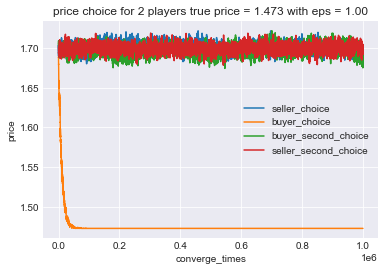

In [8]:
from matplotlib import pyplot as plt
ll = K.state_list.copy()

indexes1 = np.where(~np.isnan(K.state_list[0,:,0]))[0][-1] + 1
lll = np.full((K.numSessions,indexes1,K.game.numPlayers*2),np.nan) 
for i in range(indexes1):
    lll[0,i,0] = ll[0,i,0]//15
    lll[0,i,2] = ll[0,i,1]//15
    if lll[0,i,0] != lll[0,i,2]:
        lll[0,i,1] = ll[0,i,0]%15

        lll[0,i,3] = ll[0,i,1]%15
    else:
        lll[0,i,1] = np.nan
        lll[0,i,3] = np.nan
for i in range(15):
    lll[lll==i]=K.game.buyer_action_list[::15,0][i]
    
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
    if i%100000 ==0:
        print(i)
    if i>=1000:
        buyer_list = lll[0,i-1000:i,0]
        buyer_brother_list = lll[0,i-1000:i,1]
        seller_list = lll[0,i-1000:i,2]
        seller_brother_list = lll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.nanmean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.nanmean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.nanmean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.nanmean(seller_brother_list)
        
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_second_choice','seller_second_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('price')
plt.title('price choice for 2 players true price = %.3f with eps = %.2f'\
          %(K.game.buyer_action_list[::15,0][int(K.c)],1))

In [83]:
K.game.buyer_action_list[4]

1.5859402247774075

In [85]:
K.game.buyer_action_list[int(K.c_index)]

1.5859402247774075

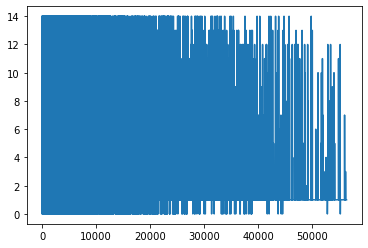

In [37]:
plt.plot(K.state_list[0,:,2])

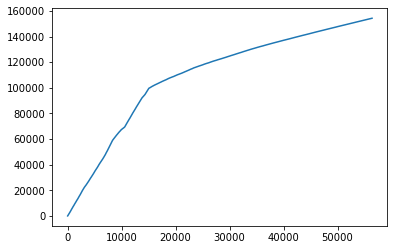

In [38]:
plt.plot(K.state_list[0,:,2].cumsum())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


Text(0.5, 1.0, 'price choice for buyer and seller and brothers')

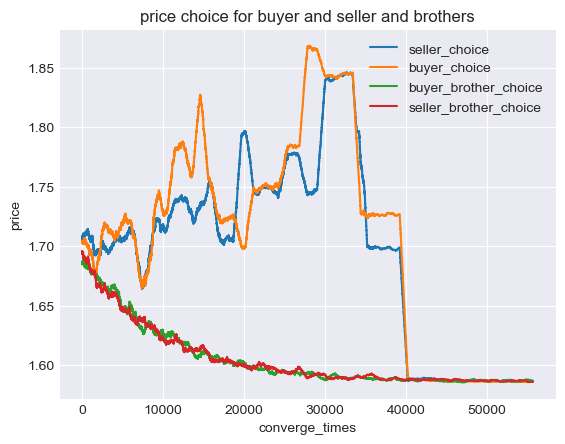

In [79]:
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_brother_choice','seller_brother_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('price')
plt.title('price choice for buyer and seller and brothers')

In [76]:
ll = K.state_list.copy()

In [75]:
plt.style

['seaborn-darkgrid']

In [18]:
ll

array([[[1.69895379, 1.62361141, 1.6612826 , 1.51059785],
        [1.69895379, 1.43525547, 1.73662498, 1.77429617],
        [1.73662498, 1.96265211, 1.69895379, 1.6612826 ],
        ...,
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]]])

In [19]:
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
    if i%1000 ==0:
        print(i)
    if i>=1000:
        buyer_list = ll[0,i-1000:i,0]
        buyer_brother_list = ll[0,i-1000:i,1]
        seller_list = ll[0,i-1000:i,2]
        seller_brother_list = ll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.mean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.mean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.mean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.mean(seller_brother_list)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


In [23]:
cost = b_model.buyer_cost_list

In [65]:
for i in ll:
    K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,
                     true_value = 1,penalty = -2,reward = 2,c = i,
                     convergedtime = 500,maxIters = 100000)
    R = K.q_learning()

    print('true_cost:',K.c_index,'     player1:',int(R[1][0][0]),'     player_brother:',int(R[1][1][0]),\
          '     player2:',int(R[1][2][0]),'     player2_brother:',int(R[1][3][0]))

true_cost: 0      player1: 0      player_brother: 0      player2: 0      player2_brother: 0
true_cost: 1      player1: 3      player_brother: 1      player2: 3      player2_brother: 1
true_cost: 2      player1: 2      player_brother: 2      player2: 2      player2_brother: 2
true_cost: 3      player1: 3      player_brother: 3      player2: 3      player2_brother: 3
true_cost: 4      player1: 13      player_brother: 4      player2: 13      player2_brother: 4
true_cost: 5      player1: 5      player_brother: 5      player2: 5      player2_brother: 5
true_cost: 6      player1: 6      player_brother: 6      player2: 6      player2_brother: 6
true_cost: 7      player1: 7      player_brother: 7      player2: 7      player2_brother: 7
true_cost: 8      player1: 8      player_brother: 8      player2: 8      player2_brother: 8
true_cost: 9      player1: 9      player_brother: 9      player2: 9      player2_brother: 9
true_cost: 10      player1: 10      player_brother: 10      player2: 10      p

In [62]:
R[1][0]

array([0.])

In [14]:
K.game.Q.shape

(50625, 15, 4)

In [290]:
lll = np.array([[196., 196., 111., 136., 201., 196., 196., 196.,  67., 151., 196.,
        140., 196.,  35., 203.,  80., 217., 199., 196., 155., 143.,  64.,
        219., 181., 196., 196., 196., 224., 196.,  60., 208., 196., 208.,
        196., 196., 217.,  82., 196., 196., 196., 223., 196., 196., 109.,
         77., 196., 140., 196., 210., 210., 196., 204., 196., 170., 196.,
        196., 152., 206.,  63., 198., 124., 196.,   5., 200., 196., 196.,
        196.,  22.,  99., 196.,  79., 196., 196., 216., 196., 196., 127.,
        203.,  32.,  90., 156., 196.,  95., 196., 171., 196.,  77.,  43.,
        172.,  84.,  55.,  19., 196., 130., 196.,  30.,  32.,  34., 151.,
         54.],
       [196., 196., 109., 137., 204., 196., 196., 196.,  65., 156., 196.,
         36., 196.,  43., 196.,  85., 211., 195., 196., 153., 144.,  69.,
        223.,   8., 196.,  14., 196., 216., 196.,  64., 206., 195., 196.,
        196., 196., 216.,  79., 196., 196., 196.,  92., 196., 196., 117.,
         77., 196., 138., 196., 210., 210., 196., 199., 196., 171., 196.,
        201.,  50., 195.,  62., 196., 120., 208.,   5., 196., 196., 196.,
        196.,  25., 101., 203., 146., 196., 196.,  20., 196., 196., 134.,
        196.,  37.,  96., 155., 196., 100., 196., 172., 196., 196., 203.,
        166.,  87., 196.,  15., 196., 127., 196.,  36.,  34., 142., 161.,
         51.]])

In [291]:
llll = lll//15
index =index0 = index1 = index2 = index3 = index4 =index5 = \
    index6 = index7 = index8 = index9 =index10 = index11 = index12 = index13 = index14 = 0
for i in range(100):
    if llll[1,i] == llll[0,i]:
        index +=1
        if llll[1,i] == 0:
            index0 +=1
        if llll[1,i] == 1:
            index1 +=1
        if llll[1,i] == 2:
            index2 +=1
        if llll[1,i] == 3:
            index3 +=1
        if llll[1,i] == 4:
            index4 +=1
        if llll[1,i] == 5:
            index5 +=1
        if llll[1,i] == 6:
            index6 +=1
        if llll[1,i] == 7:
            index7 +=1
        if llll[1,i] == 8:
            index8 +=1
        if llll[1,i] == 9:
            index9 +=1
        if llll[1,i] == 10:
            index10 +=1
        if llll[1,i] == 11:
            index11 +=1
        if llll[1,i] == 12:
            index12 +=1
        if llll[1,i] == 13:
            index13 +=1
        if llll[1,i] == 14:
            index14 +=1

Text(0.5, 1.0, '0.89')

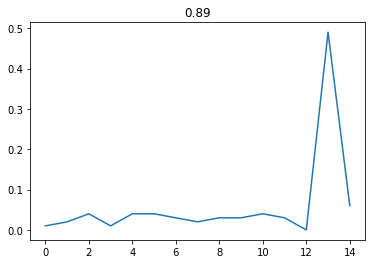

In [292]:
import matplotlib.pyplot as plt
plt.plot(range(0,15),np.array([index0/100,index1/100,index2/100,index3/100,index4/100,index5/100,index6/100,index7/100,index8/100,\
index9/100,index10/100,index11/100,index12/100,index13/100,index14/100]))
plt.title('{:.2f}'.format(index/100))

In [288]:
K.game.player_cost

array([0.95889993, 1.        , 1.04152937, 1.08352162, 1.1260071 ,
       1.16901106, 1.21255145, 1.25663669, 1.30126337, 1.34641424,
       1.39205666, 1.43814179, 1.48460469, 1.53136563, 1.57833246])

In [9]:
np.array([1,2,3])[0]

1

In [89]:
        for s in b_model.action_list:
            print(b_model.compute_profits(s))

[0.20682553 0.20682553]
[0.22155186 0.2070539 ]
[0.23600529 0.20482047]
[0.2500352  0.20041303]
[0.26350889 0.19415033]
[0.27631598 0.18636658]
[0.28837091 0.17739646]
[0.29961382 0.16756186]
[0.31000971 0.15716109]
[0.31954627 0.14646121]
[0.32823096 0.13569327]
[0.3360875  0.12505043]
[0.34315225 0.11468832]
[0.34947076 0.10472711]
[0.35509455 0.0952549 ]
[0.2070539  0.22155186]
[0.22292666 0.22292666]
[0.23866335 0.22163041]
[0.25409097 0.21792449]
[0.26905004 0.2121133 ]
[0.2834008 0.2045291]
[0.29702771 0.19551608]
[0.30984202 0.18541533]
[0.32178241 0.17455169]
[0.33281401 0.16322342]
[0.34292597 0.15169495]
[0.35212819 0.14019278]
[0.36044761 0.12890402]
[0.36792429 0.11797738]
[0.37460776 0.10752566]
[0.20482047 0.23600529]
[0.22163041 0.23866335]
[0.23846389 0.23846389]
[0.25513124 0.23563339]
[0.27145021 0.23045249]
[0.2872537  0.22324207]
[0.3023962 0.2143474]
[0.31675832 0.20412196]
[0.33024927 0.19291233]
[0.34280734 0.18104534]
[0.35439862 0.16881816]
[0.36501435 0.156491

In [90]:
b_model.compute_profits(b_model.action_list)

array([[0.00226462, 0.00226462],
       [0.00226462, 0.00211642],
       [0.00226462, 0.00196538],
       [0.00226462, 0.00181518],
       [0.00226462, 0.00166854],
       [0.00226462, 0.00152741],
       [0.00226462, 0.00139312],
       [0.00226462, 0.00126651],
       [0.00226462, 0.00114806],
       [0.00226462, 0.00103797],
       [0.00226462, 0.00093621],
       [0.00226462, 0.00084261],
       [0.00226462, 0.00075688],
       [0.00226462, 0.00067865],
       [0.00226462, 0.00060749],
       [0.00211642, 0.00226462],
       [0.00211642, 0.00211642],
       [0.00211642, 0.00196538],
       [0.00211642, 0.00181518],
       [0.00211642, 0.00166854],
       [0.00211642, 0.00152741],
       [0.00211642, 0.00139312],
       [0.00211642, 0.00126651],
       [0.00211642, 0.00114806],
       [0.00211642, 0.00103797],
       [0.00211642, 0.00093621],
       [0.00211642, 0.00084261],
       [0.00211642, 0.00075688],
       [0.00211642, 0.00067865],
       [0.00211642, 0.00060749],
       [0.

In [89]:
b_model.indexActions.shape

(256, 2)

In [90]:
b_model.Profits.shape

(256, 2)

In [95]:
for i in range(K.game.numActions):
    print('____________________________________________________________________')
    b = int(K.game.indexActions[i][0])
    s = int(K.game.indexActions[i][1])

    cb,cb_a = K.game.buyer_cost_list[b]
    cs,cs_a = K.game.seller_cost_list[s]
    vb,vb_a = K.game.buyer_action_list[b]
    vs,vs_a = K.game.seller_action_list[s]
    penalb = 0
    penals = 0
    
    print('cb:',cb,'cs:',cs,'cb_a:',cb_a,'cs_a:',cs_a)
    print('buyer profits:',K.game.Profits[i][0])
    print('seller profits:',K.game.Profits[i][1])

____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 0.5257528425553404
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.0
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.531365625336648
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 2.0817315522524162
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
________________________________________________________________

In [122]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (c,))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (c,))
    return p_competitive, p_monopoly

In [123]:
compute_p_competitive_monopoly(1)

(array([1.47292666, 1.47292666]), array([1.92498092, 1.92498092]))

In [124]:
compute_p_competitive_monopoly(0.52)

(array([1.01522646, 1.01522646]), array([1.81557214, 1.81557214]))

In [125]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (,c))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (,c))
    return p_competitive, p_monopoly

SyntaxError: invalid syntax (2600325829.py, line 3)

In [137]:
    def demand(p):
        e = np.exp((K.game.a - p) / K.game.mu)
        d = e / (np.sum(e) + np.exp(K.game.a0 / K.game.mu))
        return d
    
    def foc(p,c):

        d = demand(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu
        return np.squeeze(zero)

    
    def foc_monopoly(p,c):

        d = demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu + (p1 - c) * d1 / K.game.mu
        return np.squeeze(zero)

In [128]:
fsolve(foc,np.ones((1, 2)) * 1 * 0.52)

array([1.01522646, 1.01522646])

In [132]:
fsolve(foc_monopoly,np.ones((1, 2)) * 1 * 0.52)

array([1.81557214, 1.81557214])

In [139]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (0.52,))

array([1.81557214, 1.81557214])

In [140]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (1,))

array([1.92498092, 1.92498092])

In [150]:
fsolve(dev,3*1,args = (1,))

array([1.92498092])

In [149]:
def dev(p,c):
    zero = -p+c+K.game.mu*(1+2*np.exp((K.game.a-p-K.game.a0)/K.game.mu))
    return zero